In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# flags
flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "celebA", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [3]:
data = glob("./data/celebA/*.jpg")


sample_files = data[0:64] #change to 64 images
sample = [get_image(sample_file,
                    input_height=108,
                    input_width=None,
                    resize_height=64,
                    resize_width=64,
                    crop=True,
                    grayscale=False) for sample_file in sample_files]

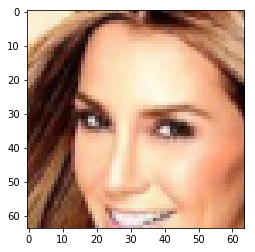

In [4]:
plt.imshow((sample[0] + 1.0)/2.0)
plt.show()

In [5]:
v = np.reshape(sample, (64, 64*64*3))
# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

shape of v: (64, 12288)


In [ ]:
# this is compressed sensing setting
m = 1000
A = np.random.randn(n, m).astype('float32')
A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
y = np.dot(v, A) 

# this is full image included setting
# m = n 
print('number of measurements = {}'.format(m))
# y = v

In [ ]:
# y_placeholder = tf.placeholder(tf.float32,[None,m])

# this loss is when we are doing compressed sensing
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 

# this loss is when we are taking image as measurement
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 

In [ ]:
y.shape

In [ ]:
#grad = tf.gradients(our_loss, dcgan.z)
#z_0 = np.random.uniform(-0.5, 0.5, size=(64 , 100))
count = 0

errs = []
    
    
with tf.Session() as sess:
    
    print(tf.global_variables())
    
    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)
    
    

    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")
    
    dcgan.z.initializer.run()
    
    y_placeholder = tf.placeholder(tf.float32,[None,m])
    
    # -----------------------------------
    # use this if we are not using A
    # our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 
    # use this if we are using A
    our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
    # -----------------------------------
    
    z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  
    
#     show_all_variables()
    
    
    opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
    beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
    beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]
    
    sess.run(opt_initializers)
    sess.run(beta1_initializers)
    sess.run(beta2_initializers)

    
    for i in range(1000): # run until error stops decreasing or reaches threshhold, then print result at that point
        print('iteration {}'.format(count))
        a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
        count += 1
        print(closs)
        errs.append(closs)
        #z_0 = z_0 - rate*a[0]
    

In [ ]:
chosen_image = 19

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow((sample[chosen_image]+1.0)/2)

ax2 = fig.add_subplot(122)
ax2.imshow((b[chosen_image]+1.0)/2)
plt.show()

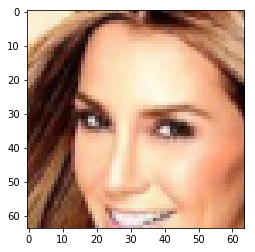

 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_bn1/

105.536
iteration 285
104.214
iteration 286
103.906
iteration 287
103.287
iteration 288
103.186
iteration 289
102.93
iteration 290
102.85
iteration 291
102.186
iteration 292
100.817
iteration 293
101.606
iteration 294
99.9732
iteration 295
101.196
iteration 296
99.763
iteration 297
99.1602
iteration 298
98.9169
iteration 299
98.153
iteration 300
98.8002
iteration 301
98.9042
iteration 302
97.2589
iteration 303
98.006
iteration 304
96.6647
iteration 305
96.2289
iteration 306
95.4331
iteration 307
95.6074
iteration 308
95.1672
iteration 309
94.9252
iteration 310
93.7411
iteration 311
94.1091
iteration 312
93.345
iteration 313
93.5313
iteration 314
92.985
iteration 315
92.4927
iteration 316
92.204
iteration 317
90.949
iteration 318
91.2454
iteration 319
90.6263
iteration 320
90.2073
iteration 321
89.5606
iteration 322
89.9869
iteration 323
89.2617
iteration 324
89.3913
iteration 325
89.6808
iteration 326
88.9394
iteration 327
88.3902
iteration 328
88.472
iteration 329
87.3161
iteration 33

30.4085
iteration 660
30.3993
iteration 661
30.5717
iteration 662
30.2866
iteration 663
30.258
iteration 664
30.4866
iteration 665
30.5821
iteration 666
29.7866
iteration 667
30.266
iteration 668
30.0362
iteration 669
30.0492
iteration 670
29.7472
iteration 671
30.0428
iteration 672
29.6233
iteration 673
30.1682
iteration 674
29.3853
iteration 675
29.2879
iteration 676
29.821
iteration 677
29.2442
iteration 678
29.5159
iteration 679
30.5841
iteration 680
30.332
iteration 681
28.8709
iteration 682
30.6682
iteration 683
29.9442
iteration 684
29.5575
iteration 685
29.9625
iteration 686
29.1839
iteration 687
30.1018
iteration 688
31.0164
iteration 689
30.078
iteration 690
31.4023
iteration 691
30.0034
iteration 692
30.5818
iteration 693
30.0944
iteration 694
29.5752
iteration 695
29.191
iteration 696
28.8908
iteration 697
29.1747
iteration 698
28.5883
iteration 699
28.8006
iteration 700
28.6443
iteration 701
28.683
iteration 702
28.5535
iteration 703
28.6346
iteration 704
28.7239
iteration

15.2906
iteration 1033
15.1278
iteration 1034
15.1753
iteration 1035
15.3513
iteration 1036
14.9566
iteration 1037
15.3353
iteration 1038
15.6608
iteration 1039
14.9477
iteration 1040
15.7867
iteration 1041
14.6586
iteration 1042
15.1582
iteration 1043
14.1935
iteration 1044
14.6278
iteration 1045
14.5875
iteration 1046
15.0285
iteration 1047
14.3821
iteration 1048
14.9939
iteration 1049
15.092
iteration 1050
15.0973
iteration 1051
15.1937
iteration 1052
14.7708
iteration 1053
14.1531
iteration 1054
13.9341
iteration 1055
13.8802
iteration 1056
13.7973
iteration 1057
13.9331
iteration 1058
13.5395
iteration 1059
14.0558
iteration 1060
13.7005
iteration 1061
13.8283
iteration 1062
13.6058
iteration 1063
13.8027
iteration 1064
13.9673
iteration 1065
14.2802
iteration 1066
14.1219
iteration 1067
14.1065
iteration 1068
13.5924
iteration 1069
13.404
iteration 1070
13.5077
iteration 1071
13.4143
iteration 1072
13.5963
iteration 1073
13.3398
iteration 1074
13.3274
iteration 1075
13.3863
itera

10.6328
iteration 1391
8.78565
iteration 1392
9.33554
iteration 1393
9.02999
iteration 1394
10.0004
iteration 1395
10.27
iteration 1396
11.5361
iteration 1397
10.7477
iteration 1398
11.5057
iteration 1399
11.0599
iteration 1400
9.88424
iteration 1401
10.7658
iteration 1402
10.8734
iteration 1403
10.2791
iteration 1404
10.4497
iteration 1405
9.54804
iteration 1406
9.90228
iteration 1407
10.364
iteration 1408
9.20531
iteration 1409
10.7551
iteration 1410
9.89791
iteration 1411
10.4175
iteration 1412
10.7113
iteration 1413
11.9811
iteration 1414
11.3202
iteration 1415
11.2694
iteration 1416
11.056
iteration 1417
10.8347
iteration 1418
9.74354
iteration 1419
10.0394
iteration 1420
9.37967
iteration 1421
9.53078
iteration 1422
9.29323
iteration 1423
9.1915
iteration 1424
8.79949
iteration 1425
8.9192
iteration 1426
8.89969
iteration 1427
8.4895
iteration 1428
8.26703
iteration 1429
8.54313
iteration 1430
8.37855
iteration 1431
7.98278
iteration 1432
8.13677
iteration 1433
7.81483
iteration 

4.77361
iteration 1750
4.73191
iteration 1751
4.73099
iteration 1752
4.66878
iteration 1753
4.67666
iteration 1754
4.89708
iteration 1755
4.68798
iteration 1756
5.05852
iteration 1757
5.74295
iteration 1758
6.20788
iteration 1759
8.15093
iteration 1760
8.49533
iteration 1761
9.44352
iteration 1762
9.39583
iteration 1763
8.14591
iteration 1764
6.35761
iteration 1765
6.25776
iteration 1766
7.46469
iteration 1767
8.14648
iteration 1768
8.72582
iteration 1769
8.93721
iteration 1770
7.26558
iteration 1771
7.27306
iteration 1772
7.85209
iteration 1773
8.13001
iteration 1774
8.47427
iteration 1775
8.204
iteration 1776
6.72871
iteration 1777
7.7258
iteration 1778
8.00695
iteration 1779
8.92921
iteration 1780
9.09505
iteration 1781
7.88341
iteration 1782
7.82686
iteration 1783
9.39306
iteration 1784
11.2711
iteration 1785
7.92218
iteration 1786
9.57701
iteration 1787
9.62431
iteration 1788
9.52801
iteration 1789
9.23172
iteration 1790
10.7663
iteration 1791
9.14424
iteration 1792
11.1539
iterat

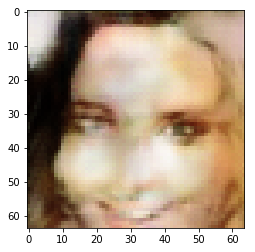

number of measurements = 100
iteration 0
1476.19
iteration 1
1240.3
iteration 2
1056.25
iteration 3
960.651
iteration 4
908.598
iteration 5
863.891
iteration 6
821.342
iteration 7
791.273
iteration 8
767.888
iteration 9
746.215
iteration 10
724.538
iteration 11
703.062
iteration 12
683.337
iteration 13
664.763
iteration 14
647.877
iteration 15
632.6
iteration 16
618.585
iteration 17
603.852
iteration 18
590.077
iteration 19
578.034
iteration 20
566.202
iteration 21
554.556
iteration 22
543.239
iteration 23
532.897
iteration 24
524.007
iteration 25
515.259
iteration 26
505.658
iteration 27
496.8
iteration 28
488.354
iteration 29
480.757
iteration 30
473.675
iteration 31
466.882
iteration 32
460.578
iteration 33
453.907
iteration 34
447.453
iteration 35
441.495
iteration 36
435.508
iteration 37
430.32
iteration 38
425.089
iteration 39
419.432
iteration 40
414.24
iteration 41
408.909
iteration 42
403.929
iteration 43
399.1
iteration 44
394.336
iteration 45
390.034
iteration 46
385.589
ite

127.519
iteration 379
127.996
iteration 380
128.265
iteration 381
127.922
iteration 382
128.082
iteration 383
127.365
iteration 384
127.592
iteration 385
126.77
iteration 386
126.809
iteration 387
126.587
iteration 388
126.929
iteration 389
126.01
iteration 390
125.825
iteration 391
125.662
iteration 392
125.363
iteration 393
124.832
iteration 394
125.192
iteration 395
124.528
iteration 396
124.587
iteration 397
125.075
iteration 398
123.979
iteration 399
125.165
iteration 400
125.002
iteration 401
124.79
iteration 402
125.542
iteration 403
125.401
iteration 404
125.488
iteration 405
124.765
iteration 406
124.422
iteration 407
125.14
iteration 408
125.177
iteration 409
124.152
iteration 410
125.094
iteration 411
124.228
iteration 412
124.891
iteration 413
124.879
iteration 414
123.797
iteration 415
124.63
iteration 416
123.369
iteration 417
122.77
iteration 418
122.127
iteration 419
122.702
iteration 420
122.26
iteration 421
121.639
iteration 422
121.574
iteration 423
121.325
iteration

93.0101
iteration 754
92.8682
iteration 755
92.6996
iteration 756
92.0798
iteration 757
92.6755
iteration 758
91.6387
iteration 759
92.1341
iteration 760
92.4326
iteration 761
92.0267
iteration 762
91.8973
iteration 763
92.1379
iteration 764
91.4104
iteration 765
92.7672
iteration 766
91.7027
iteration 767
91.9822
iteration 768
92.119
iteration 769
91.6919
iteration 770
91.4972
iteration 771
91.8709
iteration 772
91.8129
iteration 773
90.8524
iteration 774
91.5011
iteration 775
91.4133
iteration 776
91.0156
iteration 777
91.0658
iteration 778
90.7286
iteration 779
90.746
iteration 780
90.9145
iteration 781
90.768
iteration 782
90.523
iteration 783
90.033
iteration 784
89.9467
iteration 785
89.9205
iteration 786
89.5782
iteration 787
89.4343
iteration 788
89.5846
iteration 789
89.2529
iteration 790
89.1397
iteration 791
89.8017
iteration 792
89.1791
iteration 793
88.923
iteration 794
89.0165
iteration 795
88.5751
iteration 796
89.0279
iteration 797
88.2641
iteration 798
88.3997
iteratio

76.9391
iteration 1123
77.4489
iteration 1124
77.724
iteration 1125
78.1373
iteration 1126
76.8587
iteration 1127
77.3067
iteration 1128
77.344
iteration 1129
77.3673
iteration 1130
76.8978
iteration 1131
76.9899
iteration 1132
76.1822
iteration 1133
76.5276
iteration 1134
76.7364
iteration 1135
75.9974
iteration 1136
76.0113
iteration 1137
76.3065
iteration 1138
76.1337
iteration 1139
75.6228
iteration 1140
76.2088
iteration 1141
75.3926
iteration 1142
75.9673
iteration 1143
75.4193
iteration 1144
75.533
iteration 1145
75.9755
iteration 1146
76.4292
iteration 1147
77.6546
iteration 1148
78.2102
iteration 1149
77.9212
iteration 1150
77.6673
iteration 1151
78.396
iteration 1152
77.8837
iteration 1153
76.8145
iteration 1154
77.3867
iteration 1155
77.6626
iteration 1156
76.4794
iteration 1157
77.5268
iteration 1158
77.0062
iteration 1159
76.9403
iteration 1160
76.5895
iteration 1161
76.2171
iteration 1162
76.202
iteration 1163
76.1824
iteration 1164
76.9041
iteration 1165
76.4927
iteratio

69.1254
iteration 1481
69.8477
iteration 1482
69.0356
iteration 1483
69.8747
iteration 1484
70.2036
iteration 1485
70.1533
iteration 1486
69.7586
iteration 1487
70.1765
iteration 1488
69.6307
iteration 1489
70.0778
iteration 1490
68.968
iteration 1491
70.8222
iteration 1492
69.3712
iteration 1493
70.6431
iteration 1494
69.6599
iteration 1495
69.7976
iteration 1496
70.1432
iteration 1497
69.2043
iteration 1498
69.9775
iteration 1499
69.6708
iteration 1500
69.3211
iteration 1501
70.5306
iteration 1502
69.5382
iteration 1503
69.8083
iteration 1504
69.3104
iteration 1505
69.2085
iteration 1506
69.3174
iteration 1507
68.8137
iteration 1508
68.9515
iteration 1509
68.229
iteration 1510
68.542
iteration 1511
68.3481
iteration 1512
68.3256
iteration 1513
68.3896
iteration 1514
67.9041
iteration 1515
68.5968
iteration 1516
67.7451
iteration 1517
68.3324
iteration 1518
67.6112
iteration 1519
67.7124
iteration 1520
67.8867
iteration 1521
67.433
iteration 1522
67.57
iteration 1523
67.0611
iteration

62.2433
iteration 1839
62.4403
iteration 1840
61.8126
iteration 1841
62.0731
iteration 1842
62.1919
iteration 1843
62.4332
iteration 1844
62.5997
iteration 1845
62.9692
iteration 1846
61.9655
iteration 1847
62.5872
iteration 1848
62.0749
iteration 1849
61.815
iteration 1850
62.0112
iteration 1851
62.0593
iteration 1852
61.9273
iteration 1853
61.7758
iteration 1854
61.9321
iteration 1855
62.4281
iteration 1856
62.7285
iteration 1857
63.3071
iteration 1858
62.4445
iteration 1859
63.2999
iteration 1860
63.9184
iteration 1861
63.288
iteration 1862
63.2903
iteration 1863
62.6824
iteration 1864
63.2484
iteration 1865
63.3921
iteration 1866
63.0405
iteration 1867
63.6302
iteration 1868
62.9888
iteration 1869
63.5644
iteration 1870
63.7042
iteration 1871
62.5145
iteration 1872
63.7372
iteration 1873
63.0769
iteration 1874
62.1235
iteration 1875
62.3272
iteration 1876
62.5347
iteration 1877
61.9857
iteration 1878
62.1175
iteration 1879
62.5469
iteration 1880
62.3784
iteration 1881
62.7678
itera

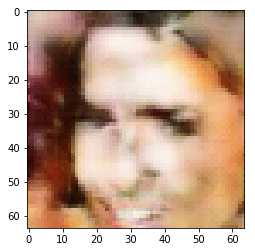

number of measurements = 200
iteration 0
897.215
iteration 1
888.73
iteration 2
775.78
iteration 3
726.145
iteration 4
687.755
iteration 5
667.993
iteration 6
647.863
iteration 7
627.054
iteration 8
608.666
iteration 9
592.575
iteration 10
576.242
iteration 11
562.417
iteration 12
550.947
iteration 13
540.285
iteration 14
529.571
iteration 15
521.04
iteration 16
511.233
iteration 17
503.003
iteration 18
496.041
iteration 19
488.299
iteration 20
481.031
iteration 21
474.898
iteration 22
467.583
iteration 23
461.06
iteration 24
455.535
iteration 25
450.204
iteration 26
445.443
iteration 27
440.369
iteration 28
435.206
iteration 29
430.582
iteration 30
426.442
iteration 31
422.283
iteration 32
418.099
iteration 33
414.013
iteration 34
410.155
iteration 35
406.506
iteration 36
402.942
iteration 37
399.312
iteration 38
395.953
iteration 39
392.617
iteration 40
389.455
iteration 41
386.281
iteration 42
383.45
iteration 43
380.557
iteration 44
377.798
iteration 45
375.132
iteration 46
372.61


205.546
iteration 379
205.654
iteration 380
205.245
iteration 381
205.149
iteration 382
205.159
iteration 383
205.12
iteration 384
204.781
iteration 385
204.721
iteration 386
203.992
iteration 387
203.933
iteration 388
203.987
iteration 389
204.569
iteration 390
204.24
iteration 391
204.188
iteration 392
204.119
iteration 393
204.351
iteration 394
203.75
iteration 395
203.566
iteration 396
204.483
iteration 397
203.248
iteration 398
203.765
iteration 399
203.465
iteration 400
203.275
iteration 401
202.689
iteration 402
202.527
iteration 403
202.67
iteration 404
202.613
iteration 405
202.092
iteration 406
201.894
iteration 407
201.665
iteration 408
201.718
iteration 409
201.657
iteration 410
201.199
iteration 411
200.924
iteration 412
200.786
iteration 413
200.254
iteration 414
202.577
iteration 415
203.043
iteration 416
201.754
iteration 417
202.344
iteration 418
201.898
iteration 419
201.076
iteration 420
201.356
iteration 421
200.806
iteration 422
200.165
iteration 423
201.22
iterati

173.589
iteration 753
174.286
iteration 754
173.871
iteration 755
173.656
iteration 756
173.835
iteration 757
173.943
iteration 758
173.761
iteration 759
173.962
iteration 760
174.333
iteration 761
174.345
iteration 762
174.283
iteration 763
174.035
iteration 764
174.619
iteration 765
174.048
iteration 766
174.907
iteration 767
174.283
iteration 768
174.226
iteration 769
174.542
iteration 770
174.031
iteration 771
174.955
iteration 772
174.493
iteration 773
174.079
iteration 774
174.801
iteration 775
174.195
iteration 776
174.891
iteration 777
175.106
iteration 778
174.06
iteration 779
174.503
iteration 780
173.99
iteration 781
173.424
iteration 782
173.673
iteration 783
173.969
iteration 784
173.96
iteration 785
174.805
iteration 786
176.701
iteration 787
175.925
iteration 788
176.392
iteration 789
174.965
iteration 790
175.182
iteration 791
174.348
iteration 792
175.2
iteration 793
174.465
iteration 794
173.804
iteration 795
173.628
iteration 796
173.394
iteration 797
173.234
iterati

162.311
iteration 1122
162.428
iteration 1123
162.67
iteration 1124
162.715
iteration 1125
162.313
iteration 1126
162.605
iteration 1127
162.924
iteration 1128
162.773
iteration 1129
162.509
iteration 1130
162.832
iteration 1131
162.288
iteration 1132
162.472
iteration 1133
164.215
iteration 1134
162.468
iteration 1135
163.402
iteration 1136
162.743
iteration 1137
162.357
iteration 1138
162.289
iteration 1139
162.212
iteration 1140
161.95
iteration 1141
162.594
iteration 1142
162.842
iteration 1143
162.772
iteration 1144
162.44
iteration 1145
162.701
iteration 1146
162.145
iteration 1147
162.602
iteration 1148
161.546
iteration 1149
161.926
iteration 1150
161.259
iteration 1151
161.126
iteration 1152
161.354
iteration 1153
161.299
iteration 1154
161.828
iteration 1155
163.152
iteration 1156
162.234
iteration 1157
162.263
iteration 1158
162.179
iteration 1159
162.945
iteration 1160
167.566
iteration 1161
169.205
iteration 1162
170.425
iteration 1163
169.355
iteration 1164
167.832
iterat

154.214
iteration 1480
153.588
iteration 1481
153.299
iteration 1482
153.594
iteration 1483
152.823
iteration 1484
153.746
iteration 1485
152.618
iteration 1486
153.228
iteration 1487
152.706
iteration 1488
152.456
iteration 1489
152.776
iteration 1490
152.238
iteration 1491
152.235
iteration 1492
152.056
iteration 1493
152.44
iteration 1494
152.137
iteration 1495
152.399
iteration 1496
153.141
iteration 1497
152.705
iteration 1498
153.473
iteration 1499
154.318
iteration 1500
153.308
iteration 1501
153.559
iteration 1502
152.408
iteration 1503
152.993
iteration 1504
152.502
iteration 1505
152.342
iteration 1506
152.419
iteration 1507
152.347
iteration 1508
152.116
iteration 1509
151.984
iteration 1510
151.878
iteration 1511
151.837
iteration 1512
151.969
iteration 1513
152.051
iteration 1514
152.567
iteration 1515
152.27
iteration 1516
151.965
iteration 1517
153.093
iteration 1518
153.09
iteration 1519
152.877
iteration 1520
152.943
iteration 1521
152.45
iteration 1522
152.295
iterati

149.775
iteration 1838
150.87
iteration 1839
149.443
iteration 1840
149.325
iteration 1841
149.401
iteration 1842
148.351
iteration 1843
148.686
iteration 1844
148.664
iteration 1845
148.602
iteration 1846
149.143
iteration 1847
148.049
iteration 1848
147.806
iteration 1849
148.202
iteration 1850
147.742
iteration 1851
147.765
iteration 1852
148.119
iteration 1853
148.246
iteration 1854
147.91
iteration 1855
148.242
iteration 1856
147.801
iteration 1857
147.934
iteration 1858
147.465
iteration 1859
148.09
iteration 1860
147.35
iteration 1861
147.715
iteration 1862
147.453
iteration 1863
147.743
iteration 1864
147.476
iteration 1865
147.318
iteration 1866
147.51
iteration 1867
147.062
iteration 1868
147.364
iteration 1869
147.742
iteration 1870
147.61
iteration 1871
148.03
iteration 1872
147.699
iteration 1873
148.085
iteration 1874
147.752
iteration 1875
147.785
iteration 1876
148.183
iteration 1877
147.479
iteration 1878
147.581
iteration 1879
147.16
iteration 1880
146.912
iteration 1

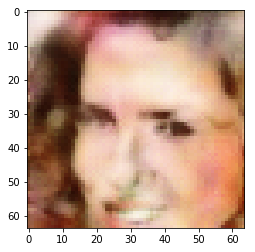

number of measurements = 500
iteration 0
531.94
iteration 1
718.519
iteration 2
565.544
iteration 3
552.059
iteration 4
548.928
iteration 5
532.174
iteration 6
509.176
iteration 7
495.566
iteration 8
486.455
iteration 9
475.684
iteration 10
464.804
iteration 11
457.16
iteration 12
450.089
iteration 13
441.744
iteration 14
434.146
iteration 15
427.717
iteration 16
421.816
iteration 17
415.79
iteration 18
410.577
iteration 19
406.692
iteration 20
402.656
iteration 21
398.608
iteration 22
394.534
iteration 23
390.652
iteration 24
387.618
iteration 25
384.362
iteration 26
381.03
iteration 27
377.546
iteration 28
374.507
iteration 29
372.46
iteration 30
369.853
iteration 31
367.361
iteration 32
364.955
iteration 33
362.816
iteration 34
360.582
iteration 35
358.48
iteration 36
356.609
iteration 37
354.86
iteration 38
353.227
iteration 39
351.368
iteration 40
349.649
iteration 41
347.844
iteration 42
346.439
iteration 43
344.813
iteration 44
343.459
iteration 45
341.881
iteration 46
340.612
i

254.327
iteration 379
253.956
iteration 380
253.559
iteration 381
253.611
iteration 382
253.003
iteration 383
253.002
iteration 384
253.141
iteration 385
253.032
iteration 386
252.9
iteration 387
253.438
iteration 388
252.67
iteration 389
252.88
iteration 390
252.237
iteration 391
252.626
iteration 392
251.774
iteration 393
252.385
iteration 394
252.515
iteration 395
252.671
iteration 396
252.666
iteration 397
252.537
iteration 398
252.184
iteration 399
251.455
iteration 400
251.474
iteration 401
251.214
iteration 402
251.417
iteration 403
251.653
iteration 404
251.645
iteration 405
251.858
iteration 406
251.86
iteration 407
251.552
iteration 408
251.439
iteration 409
251.052
iteration 410
250.7
iteration 411
250.819
iteration 412
250.538
iteration 413
250.47
iteration 414
250.548
iteration 415
250.35
iteration 416
250.459
iteration 417
250.402
iteration 418
250.433
iteration 419
250.32
iteration 420
250.46
iteration 421
250.575
iteration 422
250.244
iteration 423
250.029
iteration 424

237.316
iteration 754
237.246
iteration 755
236.71
iteration 756
236.923
iteration 757
236.785
iteration 758
236.614
iteration 759
236.972
iteration 760
236.422
iteration 761
236.826
iteration 762
237.353
iteration 763
237.113
iteration 764
237.227
iteration 765
236.917
iteration 766
236.906
iteration 767
237.156
iteration 768
236.824
iteration 769
237.191
iteration 770
237.316
iteration 771
236.936
iteration 772
236.944
iteration 773
236.752
iteration 774
236.597
iteration 775
236.181
iteration 776
236.292
iteration 777
236.811
iteration 778
236.463
iteration 779
236.65
iteration 780
236.678
iteration 781
237.07
iteration 782
237.185
iteration 783
237.703
iteration 784
236.732
iteration 785
236.745
iteration 786
236.478
iteration 787
236.091
iteration 788
236.036
iteration 789
235.9
iteration 790
235.853
iteration 791
235.943
iteration 792
236.22
iteration 793
235.701
iteration 794
236.139
iteration 795
236.355
iteration 796
236.488
iteration 797
236.077
iteration 798
236.028
iteratio

228.551
iteration 1123
228.624
iteration 1124
228.351
iteration 1125
228.179
iteration 1126
228.471
iteration 1127
228.493
iteration 1128
228.16
iteration 1129
228.25
iteration 1130
228.355
iteration 1131
228.138
iteration 1132
228.254
iteration 1133
228.083
iteration 1134
228.295
iteration 1135
228.592
iteration 1136
229.083
iteration 1137
230.122
iteration 1138
229.949
iteration 1139
229.629
iteration 1140
229.038
iteration 1141
228.426
iteration 1142
228.799
iteration 1143
229.069
iteration 1144
229.34
iteration 1145
229.415
iteration 1146
229.17
iteration 1147
229.006
iteration 1148
228.652
iteration 1149
228.968
iteration 1150
228.831
iteration 1151
228.759
iteration 1152
228.934
iteration 1153
228.908
iteration 1154
227.994
iteration 1155
228.199
iteration 1156
228.685
iteration 1157
227.96
iteration 1158
228.293
iteration 1159
228.497
iteration 1160
228.549
iteration 1161
228.59
iteration 1162
228.481
iteration 1163
228.005
iteration 1164
228.302
iteration 1165
227.899
iteration

224.124
iteration 1482
224.015
iteration 1483
224.155
iteration 1484
223.912
iteration 1485
223.889
iteration 1486
224.015
iteration 1487
224.036
iteration 1488
223.768
iteration 1489
224.064
iteration 1490
223.6
iteration 1491
223.436
iteration 1492
223.582
iteration 1493
223.318
iteration 1494
223.796
iteration 1495
223.796
iteration 1496
223.204
iteration 1497
223.42
iteration 1498
223.347
iteration 1499
223.339
iteration 1500
223.296
iteration 1501
223.299
iteration 1502
223.418
iteration 1503
223.173
iteration 1504
223.319
iteration 1505
223.922
iteration 1506
224.176
iteration 1507
223.87
iteration 1508
223.657
iteration 1509
223.363
iteration 1510
223.221
iteration 1511
223.029
iteration 1512
223.096
iteration 1513
223.423
iteration 1514
223.426
iteration 1515
223.805
iteration 1516
224.146
iteration 1517
224.267
iteration 1518
223.477
iteration 1519
223.582
iteration 1520
223.203
iteration 1521
223.32
iteration 1522
223.026
iteration 1523
223.264
iteration 1524
223.708
iteratio

220.921
iteration 1841
220.758
iteration 1842
221.037
iteration 1843
220.955
iteration 1844
221.062
iteration 1845
220.769
iteration 1846
220.626
iteration 1847
220.549
iteration 1848
220.105
iteration 1849
220.137
iteration 1850
220.444
iteration 1851
220.607
iteration 1852
221.156
iteration 1853
221.403
iteration 1854
221.28
iteration 1855
221.36
iteration 1856
220.869
iteration 1857
220.359
iteration 1858
221.389
iteration 1859
220.735
iteration 1860
221.488
iteration 1861
220.667
iteration 1862
221.219
iteration 1863
221.079
iteration 1864
220.614
iteration 1865
220.68
iteration 1866
220.698
iteration 1867
220.749
iteration 1868
221.045
iteration 1869
221.455
iteration 1870
221.24
iteration 1871
221.467
iteration 1872
221.146
iteration 1873
220.182
iteration 1874
220.903
iteration 1875
220.304
iteration 1876
220.476
iteration 1877
220.778
iteration 1878
220.704
iteration 1879
220.619
iteration 1880
219.988
iteration 1881
220.296
iteration 1882
220.467
iteration 1883
219.744
iterati

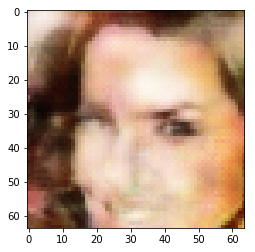

number of measurements = 1000
iteration 0
361.953
iteration 1
703.807
iteration 2
464.858
iteration 3
473.246
iteration 4
481.103
iteration 5
463.301
iteration 6
438.926
iteration 7
422.01
iteration 8
417.627
iteration 9
412.701
iteration 10
403.742
iteration 11
394.354
iteration 12
385.428
iteration 13
378.051
iteration 14
371.209
iteration 15
366.316
iteration 16
361.574
iteration 17
356.857
iteration 18
352.278
iteration 19
348.165
iteration 20
344.82
iteration 21
342.359
iteration 22
339.069
iteration 23
335.947
iteration 24
333.215
iteration 25
330.094
iteration 26
328.264
iteration 27
326.883
iteration 28
324.807
iteration 29
322.643
iteration 30
320.85
iteration 31
319.068
iteration 32
317.053
iteration 33
315.884
iteration 34
315.045
iteration 35
313.641
iteration 36
312.278
iteration 37
311.013
iteration 38
309.839
iteration 39
308.528
iteration 40
307.6
iteration 41
306.838
iteration 42
305.88
iteration 43
304.946
iteration 44
304.167
iteration 45
303.335
iteration 46
302.667

258.525
iteration 379
258.627
iteration 380
258.292
iteration 381
258.657
iteration 382
258.585
iteration 383
258.514
iteration 384
258.842
iteration 385
258.767
iteration 386
258.593
iteration 387
258.283
iteration 388
258.065
iteration 389
257.928
iteration 390
257.917
iteration 391
258.026
iteration 392
258.037
iteration 393
258.09
iteration 394
258.14
iteration 395
258.497
iteration 396
258.485
iteration 397
258.786
iteration 398
259.026
iteration 399
259.217
iteration 400
258.26
iteration 401
257.921
iteration 402
258.285
iteration 403
257.673
iteration 404
257.731
iteration 405
258.32
iteration 406
258.152
iteration 407
257.811
iteration 408
257.727
iteration 409
257.713
iteration 410
257.45
iteration 411
257.396
iteration 412
257.263
iteration 413
257.198
iteration 414
257.034
iteration 415
257.116
iteration 416
257.365
iteration 417
257.138
iteration 418
257.42
iteration 419
258.167
iteration 420
257.933
iteration 421
257.939
iteration 422
259.033
iteration 423
259.239
iteratio

249.596
iteration 754
249.263
iteration 755
249.142
iteration 756
249.122
iteration 757
249.362
iteration 758
249.19
iteration 759
249.291
iteration 760
249.257
iteration 761
249.128
iteration 762
249.349
iteration 763
249.569
iteration 764
248.932
iteration 765
249.19
iteration 766
248.969
iteration 767
249.282
iteration 768
249.329
iteration 769
249.068
iteration 770
249.769
iteration 771
249.283
iteration 772
249.522
iteration 773
249.41
iteration 774
249.441
iteration 775
249.532
iteration 776
249.494
iteration 777
249.4
iteration 778
249.801
iteration 779
249.219
iteration 780
249.14
iteration 781
249.06
iteration 782
249.358
iteration 783
249.563
iteration 784
248.829
iteration 785
249.402
iteration 786
249.218
iteration 787
248.659
iteration 788
249.531
iteration 789
249.351
iteration 790
249.437
iteration 791
249.319
iteration 792
249.345
iteration 793
249.659
iteration 794
249.96
iteration 795
249.843
iteration 796
250.236
iteration 797
250.149
iteration 798
249.372
iteration 

246.552
iteration 1123
246.806
iteration 1124
246.473
iteration 1125
246.662
iteration 1126
246.739
iteration 1127
246.89
iteration 1128
246.151
iteration 1129
246.074
iteration 1130
245.716
iteration 1131
246.158
iteration 1132
246.145
iteration 1133
246.313
iteration 1134
246.163
iteration 1135
246.092
iteration 1136
245.92
iteration 1137
245.677
iteration 1138
245.694
iteration 1139
245.593
iteration 1140
245.717
iteration 1141
245.634
iteration 1142
245.193
iteration 1143
245.435
iteration 1144
245.514
iteration 1145
245.039
iteration 1146
245.187
iteration 1147
245.358
iteration 1148
245.311
iteration 1149
245.678
iteration 1150
246.059
iteration 1151
246.156
iteration 1152
246.642
iteration 1153
246.852
iteration 1154
246.007
iteration 1155
246.087
iteration 1156
245.521
iteration 1157
245.279
iteration 1158
245.519
iteration 1159
245.685
iteration 1160
245.687
iteration 1161
245.448
iteration 1162
245.748
iteration 1163
245.576
iteration 1164
245.291
iteration 1165
245.792
itera

243.356
iteration 1481
243.447
iteration 1482
243.582
iteration 1483
243.776
iteration 1484
243.779
iteration 1485
243.49
iteration 1486
243.165
iteration 1487
243.142
iteration 1488
243.008
iteration 1489
243.012
iteration 1490
242.796
iteration 1491
243.226
iteration 1492
243.072
iteration 1493
243.177
iteration 1494
243.562
iteration 1495
243.281
iteration 1496
243.786
iteration 1497
243.909
iteration 1498
243.353
iteration 1499
243.532
iteration 1500
243.832
iteration 1501
243.765
iteration 1502
243.884
iteration 1503
243.552
iteration 1504
243.474
iteration 1505
243.777
iteration 1506
243.64
iteration 1507
244.051
iteration 1508
244.143
iteration 1509
243.695
iteration 1510
243.942
iteration 1511
243.397
iteration 1512
243.711
iteration 1513
243.04
iteration 1514
243.392
iteration 1515
243.38
iteration 1516
243.247
iteration 1517
243.47
iteration 1518
243.537
iteration 1519
243.472
iteration 1520
244.097
iteration 1521
244.503
iteration 1522
244.807
iteration 1523
244.541
iteratio

242.147
iteration 1839
242.156
iteration 1840
242.25
iteration 1841
241.9
iteration 1842
242.058
iteration 1843
241.704
iteration 1844
241.622
iteration 1845
241.812
iteration 1846
241.93
iteration 1847
241.975
iteration 1848
241.608
iteration 1849
241.469
iteration 1850
241.757
iteration 1851
241.711
iteration 1852
242.192
iteration 1853
241.841
iteration 1854
242.345
iteration 1855
242.174
iteration 1856
242.26
iteration 1857
242.412
iteration 1858
241.951
iteration 1859
241.649
iteration 1860
242.011
iteration 1861
241.887
iteration 1862
241.761
iteration 1863
241.723
iteration 1864
242.042
iteration 1865
241.834
iteration 1866
242.374
iteration 1867
241.797
iteration 1868
241.836
iteration 1869
242.062
iteration 1870
241.668
iteration 1871
242.238
iteration 1872
241.519
iteration 1873
242.013
iteration 1874
241.631
iteration 1875
241.352
iteration 1876
241.719
iteration 1877
241.303
iteration 1878
241.568
iteration 1879
241.322
iteration 1880
241.413
iteration 1881
241.223
iteratio

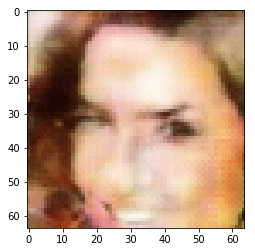

number of measurements = 2500
iteration 0
305.435
iteration 1
671.213
iteration 2
439.317
iteration 3
431.455
iteration 4
446.151
iteration 5
427.089
iteration 6
403.073
iteration 7
391.492
iteration 8
385.541
iteration 9
377.999
iteration 10
367.379
iteration 11
356.82
iteration 12
351.735
iteration 13
349.945
iteration 14
345.658
iteration 15
337.686
iteration 16
333.128
iteration 17
330.471
iteration 18
326.078
iteration 19
322.903
iteration 20
320.71
iteration 21
317.958
iteration 22
315.066
iteration 23
313.251
iteration 24
311.591
iteration 25
308.92
iteration 26
306.12
iteration 27
304.533
iteration 28
303.276
iteration 29
301.445
iteration 30
299.907
iteration 31
298.545
iteration 32
297.306
iteration 33
296.306
iteration 34
295.272
iteration 35
294.299
iteration 36
293.437
iteration 37
292.461
iteration 38
291.556
iteration 39
290.758
iteration 40
290.11
iteration 41
289.411
iteration 42
288.84
iteration 43
288.149
iteration 44
287.438
iteration 45
287.01
iteration 46
286.499


264.629
iteration 379
264.434
iteration 380
264.606
iteration 381
264.387
iteration 382
264.317
iteration 383
264.237
iteration 384
264.359
iteration 385
264.239
iteration 386
264.388
iteration 387
264.21
iteration 388
264.25
iteration 389
264.266
iteration 390
264.185
iteration 391
264.162
iteration 392
264.29
iteration 393
264.416
iteration 394
264.241
iteration 395
264.755
iteration 396
264.694
iteration 397
265.424
iteration 398
265.402
iteration 399
265.759
iteration 400
266.1
iteration 401
265.378
iteration 402
264.903
iteration 403
264.819
iteration 404
264.589
iteration 405
264.812
iteration 406
265.139
iteration 407
264.859
iteration 408
265.013
iteration 409
265.332
iteration 410
264.394
iteration 411
264.982
iteration 412
264.411
iteration 413
264.462
iteration 414
264.32
iteration 415
264.038
iteration 416
264.305
iteration 417
263.784
iteration 418
264.116
iteration 419
264.103
iteration 420
263.879
iteration 421
263.946
iteration 422
263.94
iteration 423
264.215
iteration

259.147
iteration 754
258.958
iteration 755
258.928
iteration 756
259.306
iteration 757
259.548
iteration 758
259.717
iteration 759
259.307
iteration 760
259.301
iteration 761
259.893
iteration 762
259.294
iteration 763
259.323
iteration 764
259.407
iteration 765
258.775
iteration 766
259.958
iteration 767
259.591
iteration 768
259.756
iteration 769
259.681
iteration 770
259.859
iteration 771
259.454
iteration 772
259.553
iteration 773
259.795
iteration 774
259.654
iteration 775
259.485
iteration 776
259.489
iteration 777
259.931
iteration 778
259.679
iteration 779
259.204
iteration 780
259.487
iteration 781
259.552
iteration 782
259.231
iteration 783
259.343
iteration 784
258.934
iteration 785
259.025
iteration 786
258.664
iteration 787
258.953
iteration 788
258.774
iteration 789
258.832
iteration 790
258.925
iteration 791
259.416
iteration 792
259.375
iteration 793
259.504
iteration 794
259.104
iteration 795
259.653
iteration 796
259.144
iteration 797
259.592
iteration 798
258.376
it

255.508
iteration 1123
255.559
iteration 1124
255.577
iteration 1125
256.16
iteration 1126
256.804
iteration 1127
256.952
iteration 1128
257.154
iteration 1129
256.546
iteration 1130
256.38
iteration 1131
255.836
iteration 1132
255.965
iteration 1133
256.232
iteration 1134
256.878
iteration 1135
257.274
iteration 1136
256.866
iteration 1137
256.562
iteration 1138
255.686
iteration 1139
255.855
iteration 1140
256.262
iteration 1141
256.061
iteration 1142
256.911
iteration 1143
256.427
iteration 1144
256.061
iteration 1145
255.815
iteration 1146
256.074
iteration 1147
256.251
iteration 1148
256.799
iteration 1149
256.423
iteration 1150
256.352
iteration 1151
256.049
iteration 1152
255.745
iteration 1153
255.726
iteration 1154
255.567
iteration 1155
255.908
iteration 1156
255.555
iteration 1157
255.487
iteration 1158
255.584
iteration 1159
255.305
iteration 1160
255.533
iteration 1161
255.266
iteration 1162
255.177
iteration 1163
255.239
iteration 1164
255.29
iteration 1165
255.363
iterat

253.459
iteration 1481
253.358
iteration 1482
253.579
iteration 1483
253.432
iteration 1484
253.6
iteration 1485
253.799
iteration 1486
254.011
iteration 1487
254.302
iteration 1488
254.576
iteration 1489
254.809
iteration 1490
254.73
iteration 1491
254.798
iteration 1492
254.433
iteration 1493
253.97
iteration 1494
253.914
iteration 1495
253.714
iteration 1496
254.002
iteration 1497
253.913
iteration 1498
254.269
iteration 1499
254.223
iteration 1500
254.112
iteration 1501
253.989
iteration 1502
253.688
iteration 1503
253.653
iteration 1504
253.435
iteration 1505
253.658
iteration 1506
254.095
iteration 1507
254.331
iteration 1508
254.249
iteration 1509
254.449
iteration 1510
254.125
iteration 1511
253.56
iteration 1512
253.539
iteration 1513
253.568
iteration 1514
253.634
iteration 1515
253.498
iteration 1516
253.689
iteration 1517
253.517
iteration 1518
253.253
iteration 1519
253.465
iteration 1520
253.548
iteration 1521
253.575
iteration 1522
253.646
iteration 1523
253.992
iteratio

252.156
iteration 1839
252.16
iteration 1840
252.211
iteration 1841
252.124
iteration 1842
252.065
iteration 1843
251.952
iteration 1844
251.951
iteration 1845
251.859
iteration 1846
252.128
iteration 1847
252.043
iteration 1848
251.896
iteration 1849
252.246
iteration 1850
252.421
iteration 1851
252.531
iteration 1852
252.859
iteration 1853
253.025
iteration 1854
253.595
iteration 1855
253.48
iteration 1856
253.239
iteration 1857
253.302
iteration 1858
252.876
iteration 1859
252.322
iteration 1860
252.453
iteration 1861
252.245
iteration 1862
252.145
iteration 1863
252.149
iteration 1864
252.21
iteration 1865
252.331
iteration 1866
252.283
iteration 1867
252.362
iteration 1868
252.61
iteration 1869
252.385
iteration 1870
252.619
iteration 1871
252.836
iteration 1872
252.548
iteration 1873
252.603
iteration 1874
252.535
iteration 1875
252.621
iteration 1876
252.767
iteration 1877
252.553
iteration 1878
252.421
iteration 1879
252.632
iteration 1880
252.423
iteration 1881
252.301
iterati

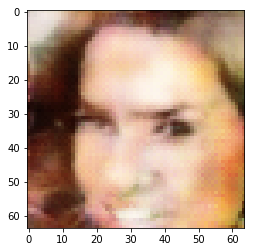

number of measurements = 5000
iteration 0
276.084
iteration 1
744.807
iteration 2
432.654
iteration 3
448.547
iteration 4
465.811
iteration 5
440.931
iteration 6
415.585
iteration 7
398.437
iteration 8
389.141
iteration 9
380.817
iteration 10
366.461
iteration 11
354.605
iteration 12
347.952
iteration 13
345.533
iteration 14
339.679
iteration 15
332.563
iteration 16
326.27
iteration 17
321.102
iteration 18
317.395
iteration 19
315.123
iteration 20
312.254
iteration 21
308.826
iteration 22
304.629
iteration 23
301.279
iteration 24
299.732
iteration 25
297.109
iteration 26
293.929
iteration 27
292.317
iteration 28
291.439
iteration 29
289.82
iteration 30
287.776
iteration 31
285.948
iteration 32
284.751
iteration 33
283.751
iteration 34
282.31
iteration 35
280.901
iteration 36
280.277
iteration 37
279.654
iteration 38
278.634
iteration 39
277.544
iteration 40
276.76
iteration 41
276.136
iteration 42
275.527
iteration 43
274.717
iteration 44
274.021
iteration 45
273.573
iteration 46
273.0

259.631
iteration 378
259.804
iteration 379
259.623
iteration 380
259.483
iteration 381
259.506
iteration 382
259.495
iteration 383
259.488
iteration 384
259.282
iteration 385
259.587
iteration 386
259.479
iteration 387
259.262
iteration 388
259.432
iteration 389
259.234
iteration 390
259.258
iteration 391
259.127
iteration 392
259.213
iteration 393
259.214
iteration 394
259.244
iteration 395
259.419
iteration 396
259.655
iteration 397
259.84
iteration 398
259.994
iteration 399
260.579
iteration 400
260.859
iteration 401
259.805
iteration 402
260.107
iteration 403
259.865
iteration 404
260.031
iteration 405
259.666
iteration 406
260.289
iteration 407
260.091
iteration 408
259.821
iteration 409
259.975
iteration 410
259.771
iteration 411
259.952
iteration 412
259.986
iteration 413
259.993
iteration 414
259.602
iteration 415
260.139
iteration 416
259.878
iteration 417
259.743
iteration 418
259.592
iteration 419
259.937
iteration 420
259.71
iteration 421
259.882
iteration 422
259.83
itera

257.734
iteration 752
257.409
iteration 753
257.15
iteration 754
256.865
iteration 755
257.137
iteration 756
257.342
iteration 757
257.426
iteration 758
257.537
iteration 759
257.392
iteration 760
257.256
iteration 761
257.047
iteration 762
257.161
iteration 763
257.075
iteration 764
257.245
iteration 765
257.559
iteration 766
257.251
iteration 767
257.441
iteration 768
257.689
iteration 769
257.307
iteration 770
257.503
iteration 771
256.974
iteration 772
257.047
iteration 773
256.68
iteration 774
256.67
iteration 775
257.096
iteration 776
256.568
iteration 777
256.874
iteration 778
256.493
iteration 779
256.652
iteration 780
256.536
iteration 781
256.473
iteration 782
256.587
iteration 783
256.456
iteration 784
256.488
iteration 785
256.416
iteration 786
256.429
iteration 787
256.481
iteration 788
256.458
iteration 789
256.374
iteration 790
256.305
iteration 791
256.433
iteration 792
256.574
iteration 793
256.923
iteration 794
257.318
iteration 795
258.078
iteration 796
258.996
itera

256.695
iteration 1122
257.69
iteration 1123
259.224
iteration 1124
259.204
iteration 1125
258.887
iteration 1126
260.014
iteration 1127
259.145
iteration 1128
258.76
iteration 1129
259.437
iteration 1130
259.268
iteration 1131
258.899
iteration 1132
258.921
iteration 1133
257.649
iteration 1134
258.379
iteration 1135
257.488
iteration 1136
258.131
iteration 1137
257.39
iteration 1138
257.303
iteration 1139
257.136
iteration 1140
256.968
iteration 1141
256.654
iteration 1142
256.982
iteration 1143
256.895
iteration 1144
256.658
iteration 1145
256.585
iteration 1146
256.418
iteration 1147
256.345
iteration 1148
256.384
iteration 1149
255.884
iteration 1150
256.298
iteration 1151
256.164
iteration 1152
255.983
iteration 1153
256.171
iteration 1154
256.109
iteration 1155
255.99
iteration 1156
255.956
iteration 1157
256.116
iteration 1158
256.157
iteration 1159
256.125
iteration 1160
256.326
iteration 1161
256.189
iteration 1162
256.24
iteration 1163
256.144
iteration 1164
255.895
iteratio

255.201
iteration 1481
255.126
iteration 1482
255.059
iteration 1483
255.084
iteration 1484
254.976
iteration 1485
255.142
iteration 1486
254.994
iteration 1487
254.755
iteration 1488
254.881
iteration 1489
255.111
iteration 1490
255.388
iteration 1491
255.771
iteration 1492
256.31
iteration 1493
256.99
iteration 1494
256.095
iteration 1495
255.574
iteration 1496
255.393
iteration 1497
255.271
iteration 1498
255.557
iteration 1499
255.674
iteration 1500
256.303
iteration 1501
256.062
iteration 1502
255.592
iteration 1503
255.967
iteration 1504
255.169
iteration 1505
255.338
iteration 1506
255.65
iteration 1507
255.366
iteration 1508
256.107
iteration 1509
255.701
iteration 1510
255.139
iteration 1511
255.289
iteration 1512
254.952
iteration 1513
254.968
iteration 1514
255.409
iteration 1515
256.335
iteration 1516
256.55
iteration 1517
255.95
iteration 1518
256.08
iteration 1519
256.555
iteration 1520
255.796
iteration 1521
255.694
iteration 1522
255.576
iteration 1523
255.374
iteration

254.015
iteration 1839
254.268
iteration 1840
254.26
iteration 1841
254.574
iteration 1842
255.151
iteration 1843
255.108
iteration 1844
255.097
iteration 1845
254.556
iteration 1846
254.385
iteration 1847
254.178
iteration 1848
254.215
iteration 1849
254.13
iteration 1850
254.208
iteration 1851
254.459
iteration 1852
254.702
iteration 1853
254.464
iteration 1854
254.325
iteration 1855
253.875
iteration 1856
253.876
iteration 1857
253.846
iteration 1858
253.846
iteration 1859
253.415
iteration 1860
253.902
iteration 1861
253.982
iteration 1862
254.063
iteration 1863
254.326
iteration 1864
254.29
iteration 1865
254.363
iteration 1866
254.82
iteration 1867
254.783
iteration 1868
254.628
iteration 1869
254.802
iteration 1870
254.383
iteration 1871
254.287
iteration 1872
254.303
iteration 1873
254.289
iteration 1874
254.765
iteration 1875
254.872
iteration 1876
254.125
iteration 1877
254.723
iteration 1878
254.769
iteration 1879
254.681
iteration 1880
254.896
iteration 1881
254.744
iterati

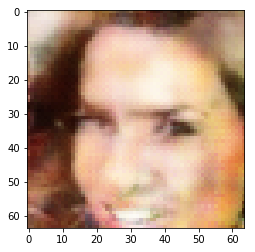

number of measurements = 7500
iteration 0
263.434
iteration 1
731.512
iteration 2
407.932
iteration 3
405.694
iteration 4
441.67
iteration 5
425.412
iteration 6
394.829
iteration 7
377.174
iteration 8
367.414
iteration 9
360.827
iteration 10
355.706
iteration 11
350.543
iteration 12
345.194
iteration 13
337.221
iteration 14
328.352
iteration 15
322.462
iteration 16
318.855
iteration 17
315.979
iteration 18
311.924
iteration 19
306.982
iteration 20
302.977
iteration 21
300.383
iteration 22
297.985
iteration 23
295.824
iteration 24
293.859
iteration 25
291.217
iteration 26
288.683
iteration 27
286.209
iteration 28
284.29
iteration 29
282.699
iteration 30
281.348
iteration 31
280.073
iteration 32
278.808
iteration 33
277.261
iteration 34
275.861
iteration 35
274.8
iteration 36
273.642
iteration 37
272.872
iteration 38
272.028
iteration 39
271.04
iteration 40
270.505
iteration 41
269.925
iteration 42
269.062
iteration 43
268.34
iteration 44
267.76
iteration 45
267.119
iteration 46
266.5
it

255.014
iteration 379
255.009
iteration 380
255.053
iteration 381
254.86
iteration 382
254.85
iteration 383
254.582
iteration 384
254.718
iteration 385
254.695
iteration 386
254.651
iteration 387
254.608
iteration 388
254.633
iteration 389
254.754
iteration 390
254.789
iteration 391
254.758
iteration 392
254.779
iteration 393
254.96
iteration 394
254.78
iteration 395
254.659
iteration 396
254.981
iteration 397
254.831
iteration 398
254.919
iteration 399
254.813
iteration 400
254.625
iteration 401
254.74
iteration 402
254.607
iteration 403
254.71
iteration 404
254.832
iteration 405
254.498
iteration 406
254.635
iteration 407
254.743
iteration 408
254.684
iteration 409
254.804
iteration 410
255.169
iteration 411
255.044
iteration 412
255.176
iteration 413
255.149
iteration 414
254.514
iteration 415
254.785
iteration 416
254.73
iteration 417
254.502
iteration 418
254.541
iteration 419
254.548
iteration 420
254.704
iteration 421
254.541
iteration 422
254.721
iteration 423
254.782
iteration

254.518
iteration 754
254.097
iteration 755
254.279
iteration 756
254.106
iteration 757
253.912
iteration 758
253.442
iteration 759
253.613
iteration 760
253.83
iteration 761
253.501
iteration 762
253.336
iteration 763
253.475
iteration 764
253.439
iteration 765
253.524
iteration 766
253.441
iteration 767
253.166
iteration 768
253.225
iteration 769
253.567
iteration 770
253.421
iteration 771
253.688
iteration 772
254.156
iteration 773
254.755
iteration 774
254.498
iteration 775
254.226
iteration 776
254.146
iteration 777
253.628
iteration 778
253.605
iteration 779
253.867
iteration 780
254.141
iteration 781
254.688
iteration 782
254.218
iteration 783
254.319
iteration 784
254.084
iteration 785
253.817
iteration 786
253.732
iteration 787
253.896
iteration 788
253.878
iteration 789
254.251
iteration 790
254.31
iteration 791
254.249
iteration 792
254.073
iteration 793
253.854
iteration 794
253.595
iteration 795
253.572
iteration 796
253.694
iteration 797
253.545
iteration 798
253.827
iter

255.824
iteration 1123
256.451
iteration 1124
256.044
iteration 1125
255.789
iteration 1126
255.522
iteration 1127
255.575
iteration 1128
255.135
iteration 1129
254.945
iteration 1130
254.463
iteration 1131
254.625
iteration 1132
254.499
iteration 1133
254.146
iteration 1134
253.947
iteration 1135
254.002
iteration 1136
254.096
iteration 1137
253.446
iteration 1138
253.74
iteration 1139
253.808
iteration 1140
253.605
iteration 1141
253.345
iteration 1142
253.707
iteration 1143
253.572
iteration 1144
253.276
iteration 1145
253.474
iteration 1146
253.637
iteration 1147
253.791
iteration 1148
254.065
iteration 1149
254.363
iteration 1150
254.543
iteration 1151
254.928
iteration 1152
254.901
iteration 1153
254.559
iteration 1154
254.308
iteration 1155
254.206
iteration 1156
255.29
iteration 1157
256.23
iteration 1158
255.277
iteration 1159
254.608
iteration 1160
254.528
iteration 1161
256.049
iteration 1162
254.041
iteration 1163
255.184
iteration 1164
255.314
iteration 1165
254.836
iterat

252.255
iteration 1481
252.306
iteration 1482
252.463
iteration 1483
252.446
iteration 1484
252.749
iteration 1485
253.464
iteration 1486
252.984
iteration 1487
252.722
iteration 1488
253.026
iteration 1489
252.476
iteration 1490
252.612
iteration 1491
252.425
iteration 1492
252.9
iteration 1493
252.444
iteration 1494
252.583
iteration 1495
252.461
iteration 1496
252.274
iteration 1497
252.284
iteration 1498
252.16
iteration 1499
252.074
iteration 1500
251.866
iteration 1501
251.906
iteration 1502
251.916
iteration 1503
251.938
iteration 1504
251.973
iteration 1505
251.974
iteration 1506
252.054
iteration 1507
252.168
iteration 1508
252.246
iteration 1509
252.312
iteration 1510
251.954
iteration 1511
252.008
iteration 1512
252.242
iteration 1513
252.067
iteration 1514
252.201
iteration 1515
252.058
iteration 1516
251.969
iteration 1517
252.282
iteration 1518
252.357
iteration 1519
252.537
iteration 1520
252.569
iteration 1521
252.429
iteration 1522
252.564
iteration 1523
252.443
iterat

252.386
iteration 1839
252.266
iteration 1840
252.134
iteration 1841
252.045
iteration 1842
252.11
iteration 1843
251.783
iteration 1844
252.166
iteration 1845
251.977
iteration 1846
252.077
iteration 1847
252.236
iteration 1848
252.069
iteration 1849
252.565
iteration 1850
252.691
iteration 1851
252.88
iteration 1852
252.691
iteration 1853
252.681
iteration 1854
252.242
iteration 1855
252.162
iteration 1856
252.146
iteration 1857
251.938
iteration 1858
252.167
iteration 1859
251.911
iteration 1860
251.918
iteration 1861
252.155
iteration 1862
252.033
iteration 1863
252.072
iteration 1864
251.849
iteration 1865
251.698
iteration 1866
251.761
iteration 1867
251.723
iteration 1868
251.746
iteration 1869
251.661
iteration 1870
251.432
iteration 1871
251.463
iteration 1872
251.367
iteration 1873
251.386
iteration 1874
251.505
iteration 1875
251.437
iteration 1876
251.582
iteration 1877
251.686
iteration 1878
251.702
iteration 1879
252.372
iteration 1880
252.553
iteration 1881
252.699
itera

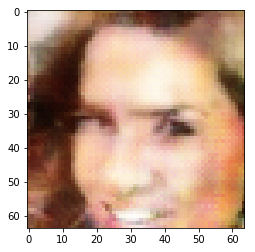

number of measurements = 10000
iteration 0
258.668
iteration 1
822.143
iteration 2
436.262
iteration 3
429.216
iteration 4
489.21
iteration 5
459.198
iteration 6
416.612
iteration 7
397.107
iteration 8
392.264
iteration 9
385.174
iteration 10
371.554
iteration 11
360.83
iteration 12
353.147
iteration 13
348.488
iteration 14
343.288
iteration 15
335.557
iteration 16
327.316
iteration 17
321.371
iteration 18
316.576
iteration 19
313.052
iteration 20
309.917
iteration 21
306.305
iteration 22
301.957
iteration 23
298.191
iteration 24
295.987
iteration 25
293.961
iteration 26
291.132
iteration 27
287.775
iteration 28
284.815
iteration 29
282.919
iteration 30
281.534
iteration 31
279.893
iteration 32
277.955
iteration 33
276.06
iteration 34
274.797
iteration 35
273.752
iteration 36
272.519
iteration 37
271.316
iteration 38
270.028
iteration 39
269.194
iteration 40
268.261
iteration 41
267.22
iteration 42
266.471
iteration 43
265.676
iteration 44
264.9
iteration 45
264.343
iteration 46
263.66

253.163
iteration 379
253.479
iteration 380
253.153
iteration 381
253.432
iteration 382
253.419
iteration 383
252.967
iteration 384
253.551
iteration 385
253.28
iteration 386
253.171
iteration 387
253.114
iteration 388
252.959
iteration 389
253.08
iteration 390
253.281
iteration 391
253.049
iteration 392
253.372
iteration 393
253.485
iteration 394
253.536
iteration 395
253.37
iteration 396
253.483
iteration 397
253.295
iteration 398
253.062
iteration 399
253.048
iteration 400
252.954
iteration 401
252.944
iteration 402
252.966
iteration 403
253.096
iteration 404
253.092
iteration 405
253.354
iteration 406
253.16
iteration 407
253.027
iteration 408
253.031
iteration 409
252.988
iteration 410
253.021
iteration 411
253.033
iteration 412
252.942
iteration 413
252.913
iteration 414
252.992
iteration 415
252.916
iteration 416
252.919
iteration 417
253.135
iteration 418
253.026
iteration 419
252.893
iteration 420
252.628
iteration 421
252.872
iteration 422
253.211
iteration 423
253.447
iterat

252.317
iteration 753
252.635
iteration 754
252.801
iteration 755
252.419
iteration 756
252.662
iteration 757
252.802
iteration 758
252.486
iteration 759
252.536
iteration 760
252.685
iteration 761
252.446
iteration 762
252.39
iteration 763
252.45
iteration 764
252.556
iteration 765
252.599
iteration 766
252.871
iteration 767
252.734
iteration 768
252.845
iteration 769
253.363
iteration 770
253.631
iteration 771
254.038
iteration 772
254.46
iteration 773
254.823
iteration 774
254.101
iteration 775
253.389
iteration 776
253.207
iteration 777
253.231
iteration 778
253.897
iteration 779
254.466
iteration 780
254.262
iteration 781
253.801
iteration 782
253.829
iteration 783
253.486
iteration 784
253.563
iteration 785
254.439
iteration 786
254.108
iteration 787
254.303
iteration 788
253.757
iteration 789
253.719
iteration 790
253.742
iteration 791
253.398
iteration 792
253.841
iteration 793
253.414
iteration 794
253.463
iteration 795
252.951
iteration 796
252.855
iteration 797
252.946
itera

252.028
iteration 1122
251.861
iteration 1123
251.715
iteration 1124
251.89
iteration 1125
251.909
iteration 1126
251.875
iteration 1127
252.091
iteration 1128
252.669
iteration 1129
253.151
iteration 1130
253.353
iteration 1131
253.63
iteration 1132
252.985
iteration 1133
252.802
iteration 1134
252.719
iteration 1135
252.608
iteration 1136
252.576
iteration 1137
253.0
iteration 1138
252.989
iteration 1139
253.052
iteration 1140
253.241
iteration 1141
252.691
iteration 1142
252.735
iteration 1143
252.284
iteration 1144
253.055
iteration 1145
253.168
iteration 1146
252.752
iteration 1147
253.132
iteration 1148
252.957
iteration 1149
252.827
iteration 1150
253.225
iteration 1151
253.335
iteration 1152
253.295
iteration 1153
253.59
iteration 1154
253.03
iteration 1155
253.385
iteration 1156
253.221
iteration 1157
253.191
iteration 1158
253.301
iteration 1159
253.369
iteration 1160
253.151
iteration 1161
253.347
iteration 1162
253.36
iteration 1163
252.711
iteration 1164
253.279
iteration 

252.01
iteration 1481
251.999
iteration 1482
251.871
iteration 1483
251.727
iteration 1484
251.658
iteration 1485
251.828
iteration 1486
251.982
iteration 1487
251.669
iteration 1488
251.728
iteration 1489
252.042
iteration 1490
252.171
iteration 1491
252.27
iteration 1492
252.372
iteration 1493
252.506
iteration 1494
252.653
iteration 1495
252.625
iteration 1496
251.909
iteration 1497
251.847
iteration 1498
252.074
iteration 1499
251.727
iteration 1500
251.827
iteration 1501
251.937
iteration 1502
252.477
iteration 1503
252.476
iteration 1504
252.224
iteration 1505
252.494
iteration 1506
252.546
iteration 1507
252.047
iteration 1508
252.12
iteration 1509
252.072
iteration 1510
251.694
iteration 1511
252.037
iteration 1512
252.345
iteration 1513
252.38
iteration 1514
252.102
iteration 1515
252.223
iteration 1516
252.229
iteration 1517
252.104
iteration 1518
252.282
iteration 1519
252.116
iteration 1520
252.673
iteration 1521
253.292
iteration 1522
253.086
iteration 1523
253.219
iterati

252.282
iteration 1839
253.126
iteration 1840
252.872
iteration 1841
252.391
iteration 1842
252.88
iteration 1843
252.71
iteration 1844
252.338
iteration 1845
252.496
iteration 1846
253.284
iteration 1847
252.476
iteration 1848
253.211
iteration 1849
252.388
iteration 1850
252.241
iteration 1851
252.052
iteration 1852
252.247
iteration 1853
251.794
iteration 1854
252.086
iteration 1855
252.704
iteration 1856
252.048
iteration 1857
252.266
iteration 1858
252.584
iteration 1859
252.034
iteration 1860
252.739
iteration 1861
251.595
iteration 1862
252.043
iteration 1863
251.91
iteration 1864
251.711
iteration 1865
251.6
iteration 1866
251.617
iteration 1867
251.516
iteration 1868
251.527
iteration 1869
251.376
iteration 1870
251.516
iteration 1871
251.319
iteration 1872
251.263
iteration 1873
251.614
iteration 1874
251.495
iteration 1875
251.605
iteration 1876
252.061
iteration 1877
252.231
iteration 1878
252.557
iteration 1879
252.712
iteration 1880
252.044
iteration 1881
251.575
iteratio

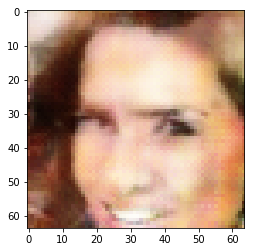

number of measurements = 12288
iteration 0
256.75
iteration 1
827.737
iteration 2
414.391
iteration 3
419.79
iteration 4
479.361
iteration 5
443.514
iteration 6
406.398
iteration 7
390.63
iteration 8
384.458
iteration 9
374.691
iteration 10
363.129
iteration 11
354.098
iteration 12
347.694
iteration 13
342.108
iteration 14
336.202
iteration 15
327.957
iteration 16
320.175
iteration 17
314.104
iteration 18
309.801
iteration 19
306.394
iteration 20
302.618
iteration 21
299.236
iteration 22
296.693
iteration 23
293.648
iteration 24
290.454
iteration 25
287.842
iteration 26
285.969
iteration 27
284.012
iteration 28
281.83
iteration 29
279.507
iteration 30
277.831
iteration 31
276.401
iteration 32
274.993
iteration 33
273.915
iteration 34
272.583
iteration 35
271.162
iteration 36
269.776
iteration 37
268.562
iteration 38
267.677
iteration 39
266.854
iteration 40
266.062
iteration 41
265.271
iteration 42
264.342
iteration 43
263.692
iteration 44
263.212
iteration 45
262.617
iteration 46
261.

252.117
iteration 379
252.313
iteration 380
252.768
iteration 381
253.217
iteration 382
252.805
iteration 383
252.926
iteration 384
252.623
iteration 385
252.52
iteration 386
252.57
iteration 387
252.294
iteration 388
252.51
iteration 389
252.798
iteration 390
252.684
iteration 391
252.906
iteration 392
252.917
iteration 393
252.416
iteration 394
252.187
iteration 395
252.398
iteration 396
252.396
iteration 397
252.606
iteration 398
252.404
iteration 399
252.447
iteration 400
252.802
iteration 401
252.195
iteration 402
252.116
iteration 403
252.171
iteration 404
252.15
iteration 405
252.285
iteration 406
252.011
iteration 407
252.162
iteration 408
252.136
iteration 409
252.223
iteration 410
252.311
iteration 411
252.171
iteration 412
252.374
iteration 413
252.336
iteration 414
252.157
iteration 415
252.324
iteration 416
252.152
iteration 417
252.004
iteration 418
252.339
iteration 419
252.455
iteration 420
251.781
iteration 421
252.179
iteration 422
252.39
iteration 423
252.142
iterati

251.397
iteration 753
251.352
iteration 754
251.39
iteration 755
251.891
iteration 756
251.867
iteration 757
251.844
iteration 758
252.409
iteration 759
252.183
iteration 760
251.852
iteration 761
251.903
iteration 762
251.744
iteration 763
251.263
iteration 764
251.382
iteration 765
251.369
iteration 766
251.772
iteration 767
251.716
iteration 768
251.883
iteration 769
252.242
iteration 770
251.892
iteration 771
251.719
iteration 772
251.745
iteration 773
252.42
iteration 774
252.097
iteration 775
251.592
iteration 776
251.61
iteration 777
251.757
iteration 778
251.701
iteration 779
251.764
iteration 780
251.907
iteration 781
251.97
iteration 782
251.735
iteration 783
251.57
iteration 784
251.853
iteration 785
251.648
iteration 786
251.642
iteration 787
251.308
iteration 788
251.487
iteration 789
251.441
iteration 790
251.35
iteration 791
251.752
iteration 792
252.099
iteration 793
251.932
iteration 794
252.075
iteration 795
252.002
iteration 796
252.52
iteration 797
252.781
iteration

250.966
iteration 1122
251.061
iteration 1123
250.914
iteration 1124
251.061
iteration 1125
251.11
iteration 1126
251.224
iteration 1127
251.292
iteration 1128
251.894
iteration 1129
252.107
iteration 1130
252.622
iteration 1131
252.048
iteration 1132
251.907
iteration 1133
251.832
iteration 1134
251.714
iteration 1135
251.541
iteration 1136
251.616
iteration 1137
251.677
iteration 1138
251.189
iteration 1139
251.484
iteration 1140
251.639
iteration 1141
251.456
iteration 1142
251.3
iteration 1143
251.09
iteration 1144
251.46
iteration 1145
251.403
iteration 1146
251.274
iteration 1147
251.141
iteration 1148
251.154
iteration 1149
250.854
iteration 1150
251.068
iteration 1151
250.771
iteration 1152
251.128
iteration 1153
250.79
iteration 1154
250.976
iteration 1155
250.858
iteration 1156
250.935
iteration 1157
251.001
iteration 1158
251.272
iteration 1159
251.733
iteration 1160
252.052
iteration 1161
252.561
iteration 1162
252.496
iteration 1163
252.405
iteration 1164
252.33
iteration 

250.971
iteration 1480
250.847
iteration 1481
250.809
iteration 1482
250.888
iteration 1483
250.576
iteration 1484
250.354
iteration 1485
250.572
iteration 1486
250.723
iteration 1487
250.695
iteration 1488
250.665
iteration 1489
250.23
iteration 1490
250.641
iteration 1491
250.632
iteration 1492
250.777
iteration 1493
250.998
iteration 1494
251.519
iteration 1495
252.123
iteration 1496
252.195
iteration 1497
252.16
iteration 1498
251.241
iteration 1499
250.969
iteration 1500
251.137
iteration 1501
250.616
iteration 1502
250.83
iteration 1503
250.914
iteration 1504
250.646
iteration 1505
250.749
iteration 1506
250.794
iteration 1507
250.751
iteration 1508
251.165
iteration 1509
251.143
iteration 1510
251.354
iteration 1511
251.647
iteration 1512
251.413
iteration 1513
251.443
iteration 1514
251.267
iteration 1515
251.197
iteration 1516
250.906
iteration 1517
250.781
iteration 1518
250.627
iteration 1519
250.381
iteration 1520
250.598
iteration 1521
250.396
iteration 1522
250.672
iterat

250.956
iteration 1838
250.857
iteration 1839
251.083
iteration 1840
251.217
iteration 1841
251.403
iteration 1842
251.23
iteration 1843
251.05
iteration 1844
250.61
iteration 1845
250.932
iteration 1846
250.763
iteration 1847
250.643
iteration 1848
250.71
iteration 1849
250.836
iteration 1850
250.585
iteration 1851
250.931
iteration 1852
250.994
iteration 1853
250.61
iteration 1854
250.461
iteration 1855
250.91
iteration 1856
251.071
iteration 1857
251.24
iteration 1858
250.978
iteration 1859
251.262
iteration 1860
251.432
iteration 1861
251.043
iteration 1862
250.745
iteration 1863
250.919
iteration 1864
250.656
iteration 1865
250.478
iteration 1866
250.609
iteration 1867
250.412
iteration 1868
250.561
iteration 1869
250.544
iteration 1870
250.646
iteration 1871
250.83
iteration 1872
250.824
iteration 1873
250.908
iteration 1874
251.125
iteration 1875
251.265
iteration 1876
251.623
iteration 1877
251.659
iteration 1878
252.115
iteration 1879
251.274
iteration 1880
251.432
iteration 1

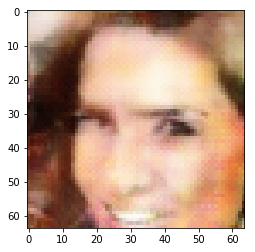

In [6]:
possible_ms = [50, 100, 200, 500, 1000, 2500, 5000, 7500, 10000, 12288]
num_iter = 2000
compressed_images = []

plt.imshow((sample[0] + 1.0)/2.0)
plt.show()


with tf.Session() as sess:

    #print(tf.global_variables())

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    for m in possible_ms:
        A = np.random.randn(n, m).astype('float32')
        A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
        y = np.dot(v, A) 

        print('number of measurements = {}'.format(m))
        count = 0
        y_placeholder = tf.placeholder(tf.float32,[None,m])

        # -----------------------------------
        our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
        # -----------------------------------

        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)


        for i in range(num_iter): 
            print('iteration {}'.format(count))
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
            count += 1
            print(closs)
        plt.imshow((b[0] + 1.0)/2.0)
        compressed_images.append(b)
        plt.show()

    

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


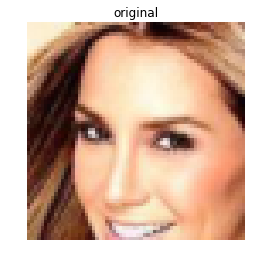

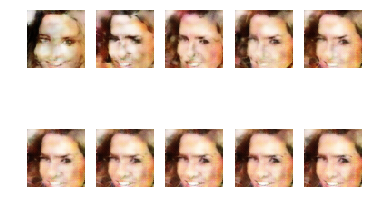

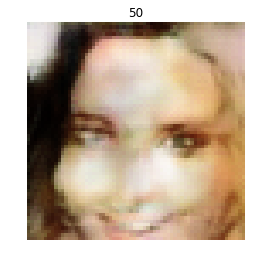

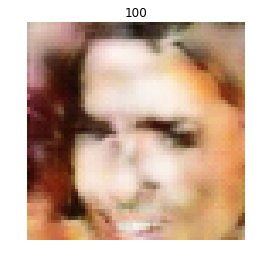

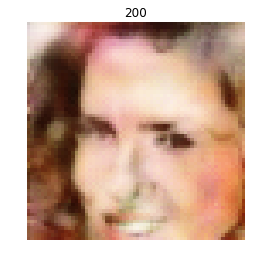

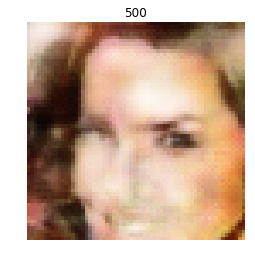

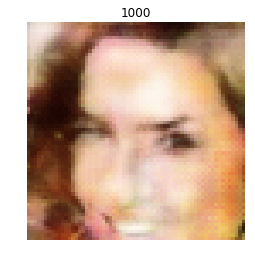

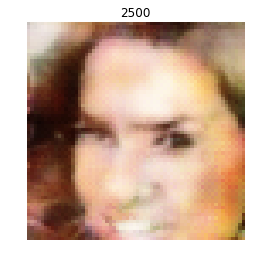

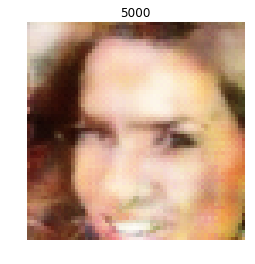

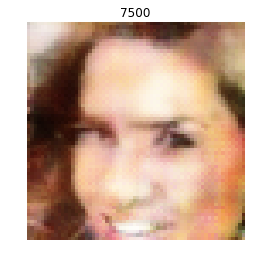

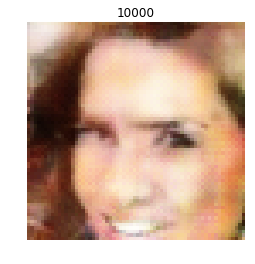

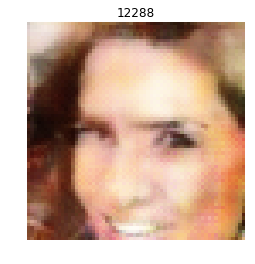

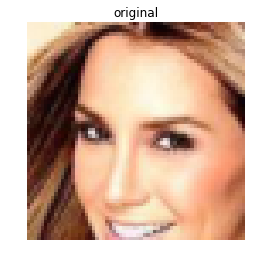

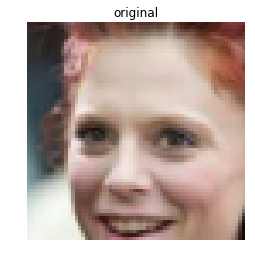

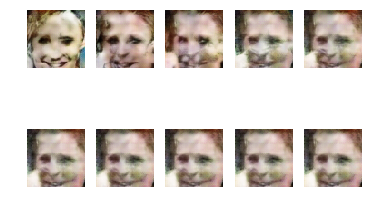

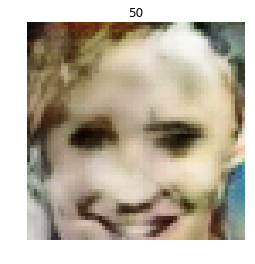

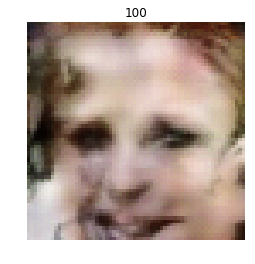

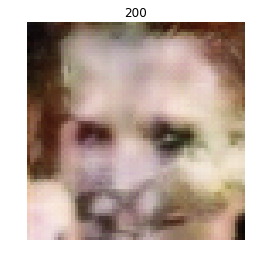

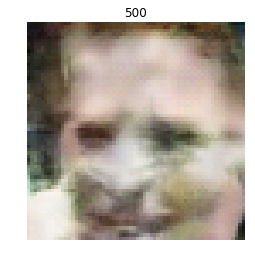

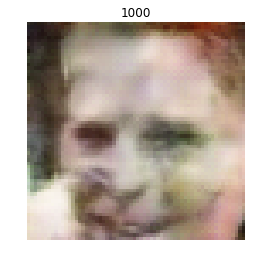

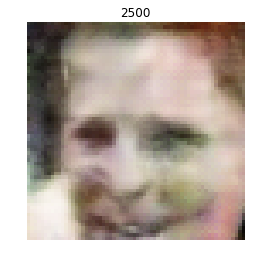

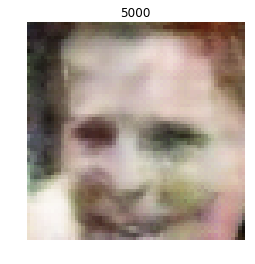

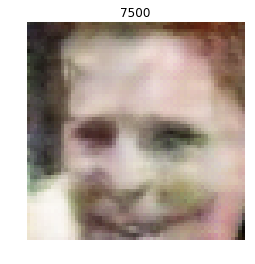

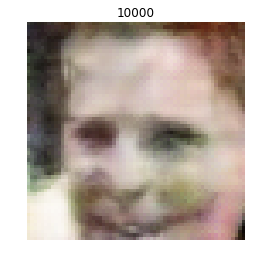

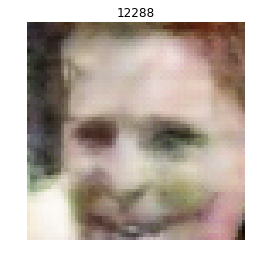

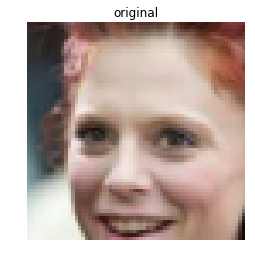

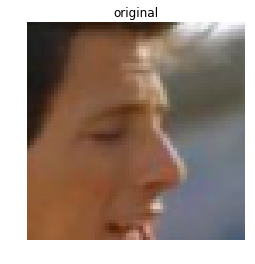

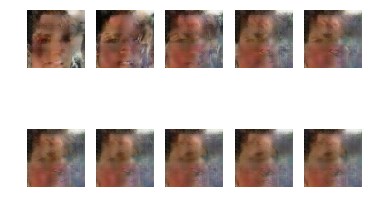

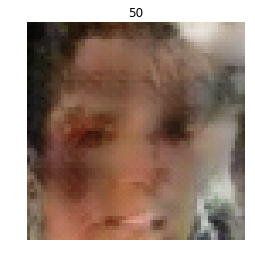

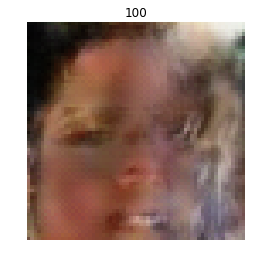

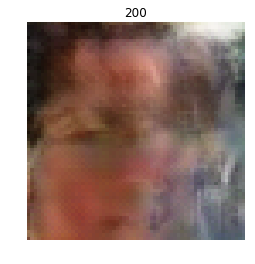

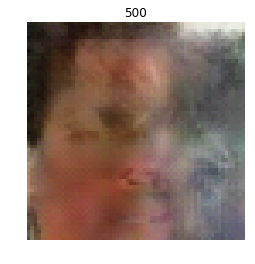

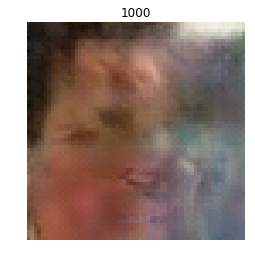

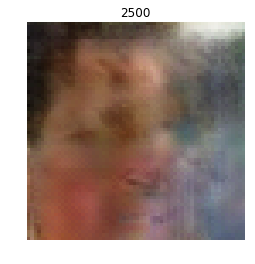

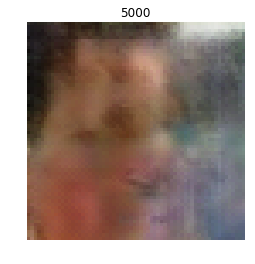

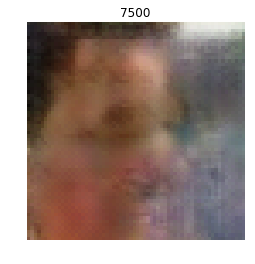

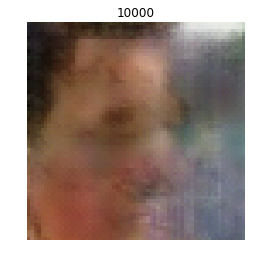

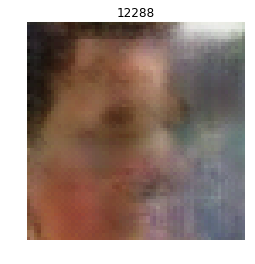

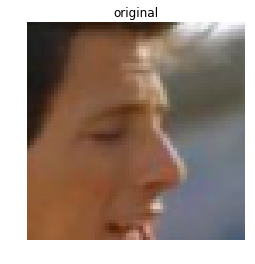

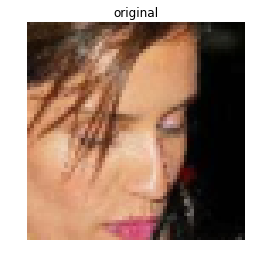

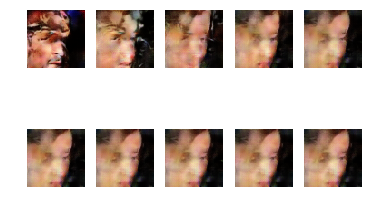

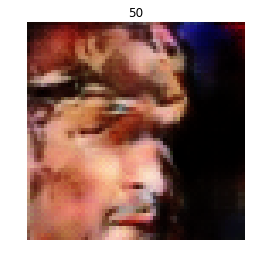

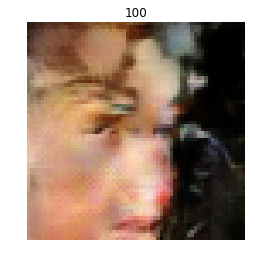

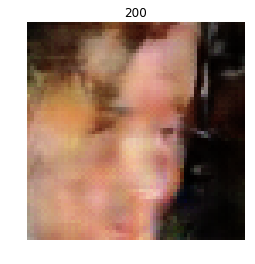

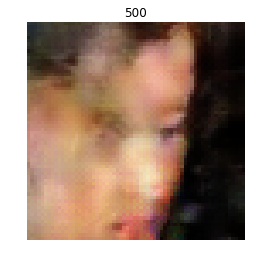

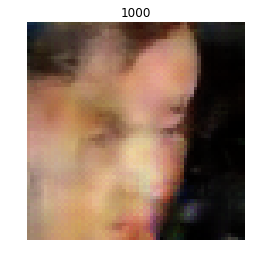

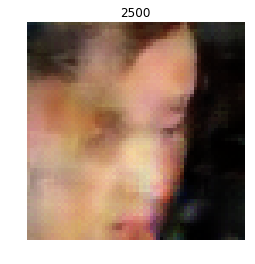

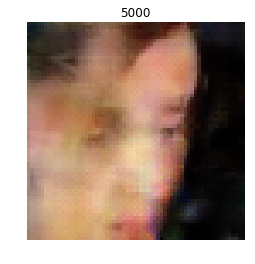

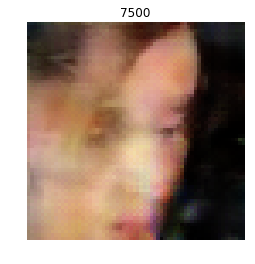

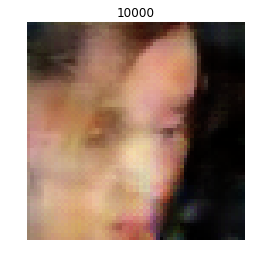

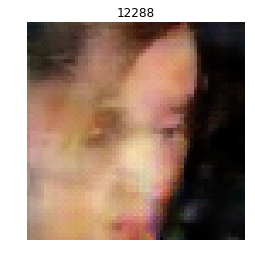

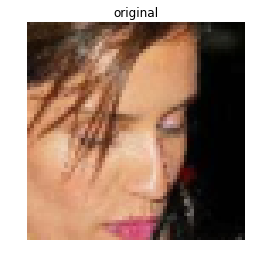

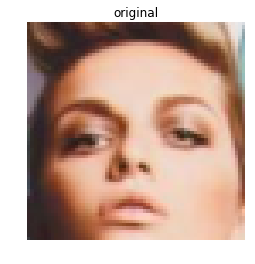

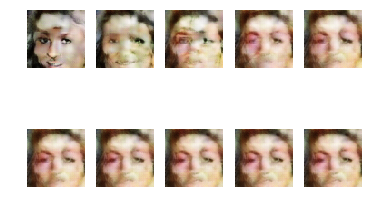

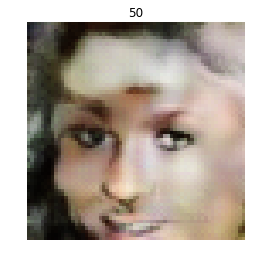

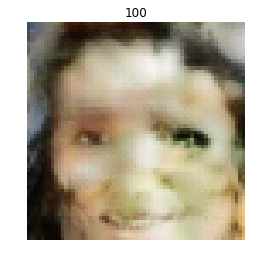

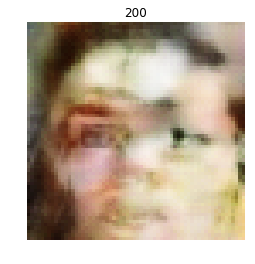

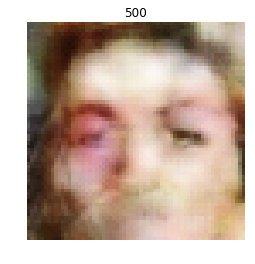

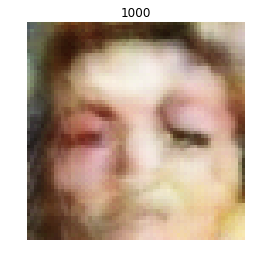

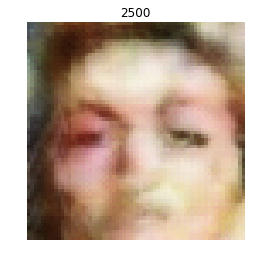

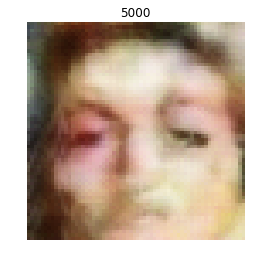

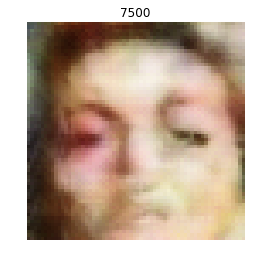

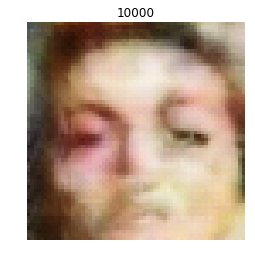

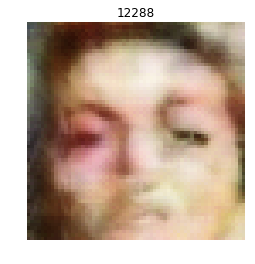

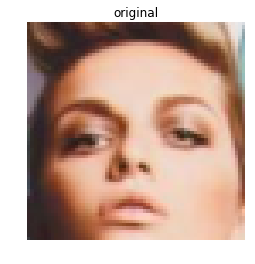

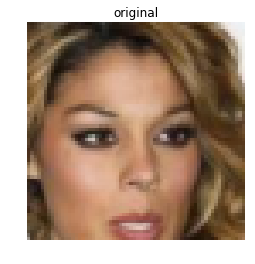

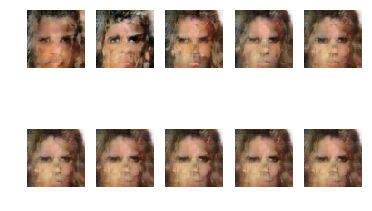

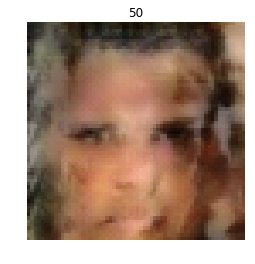

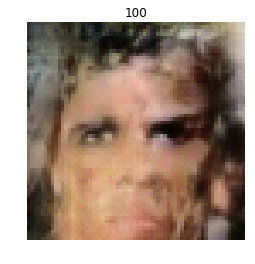

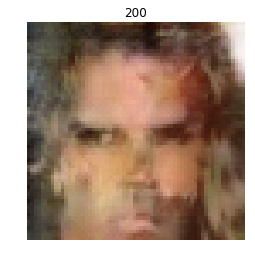

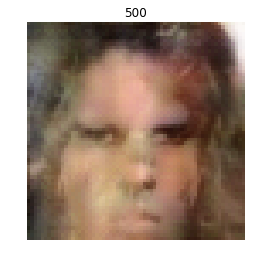

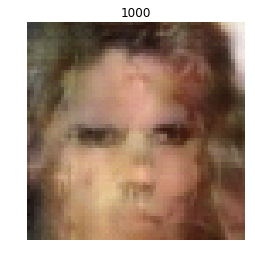

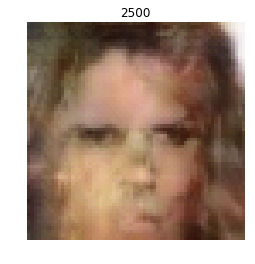

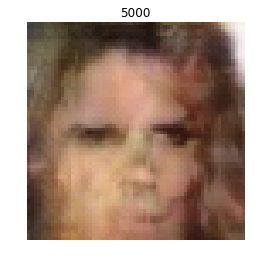

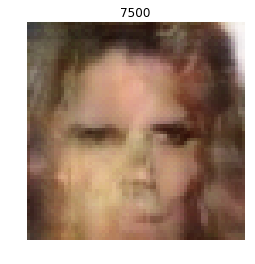

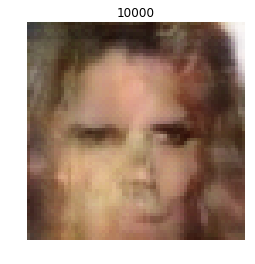

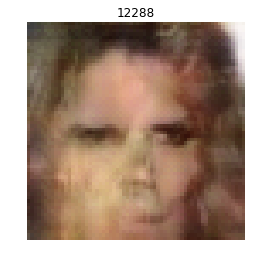

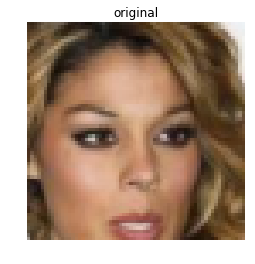

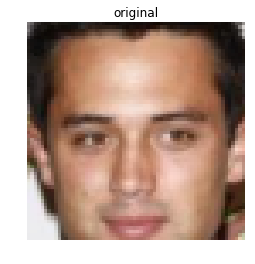

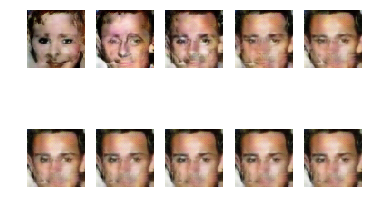

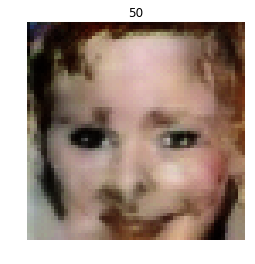

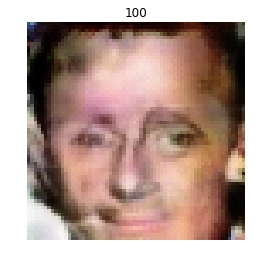

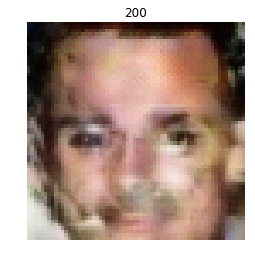

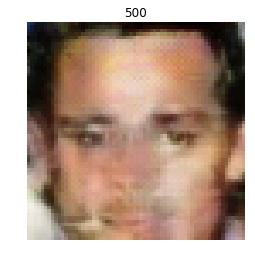

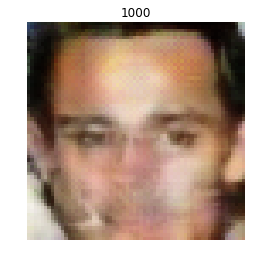

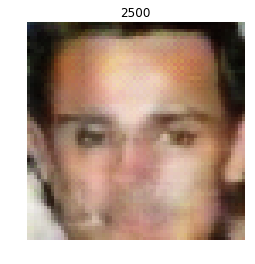

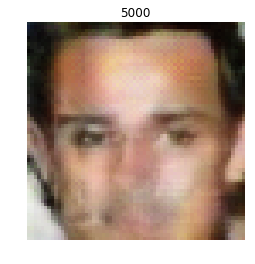

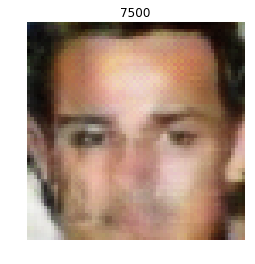

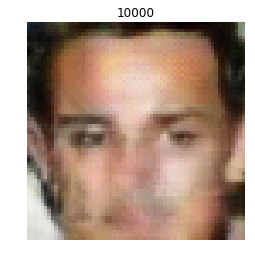

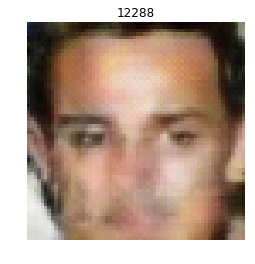

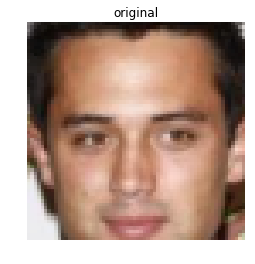

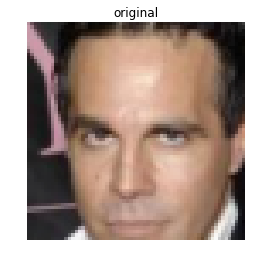

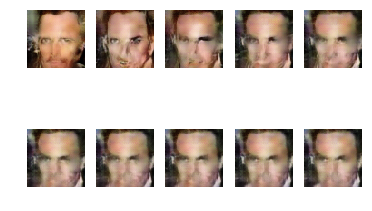

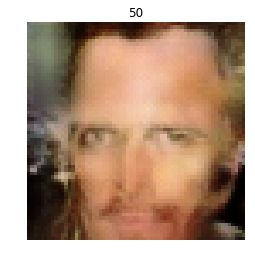

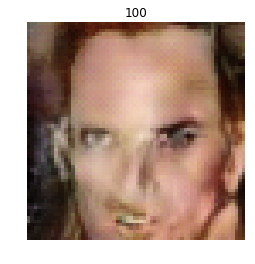

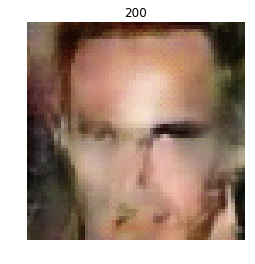

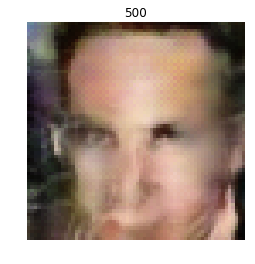

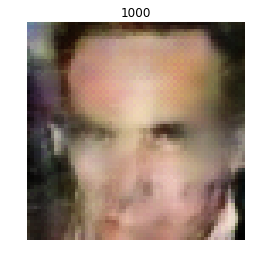

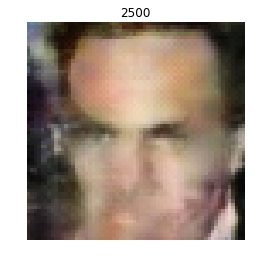

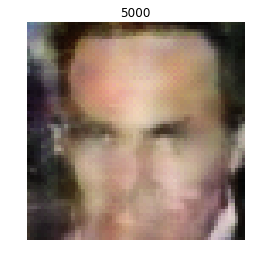

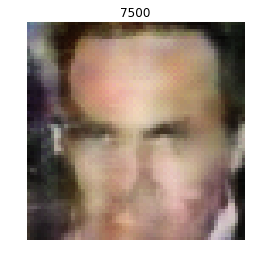

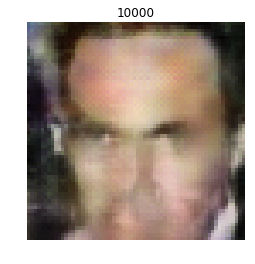

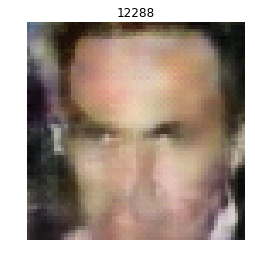

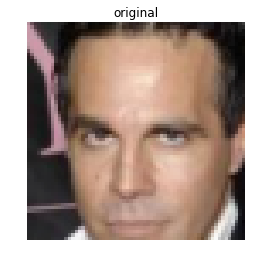

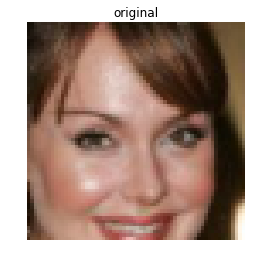

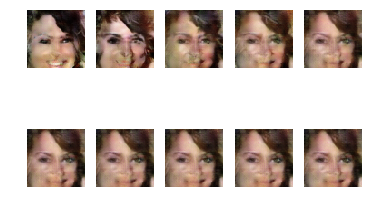

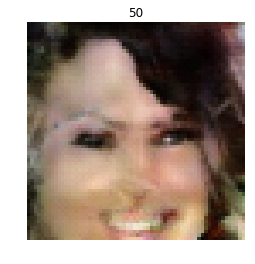

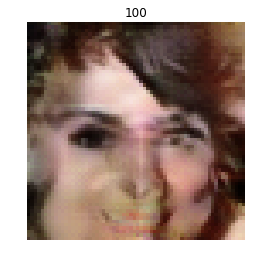

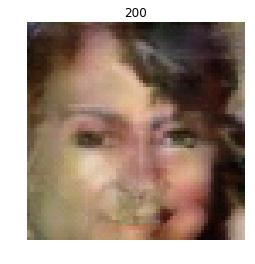

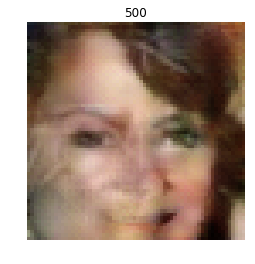

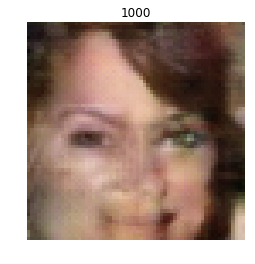

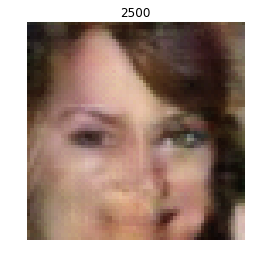

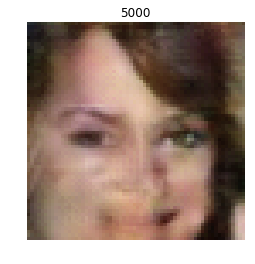

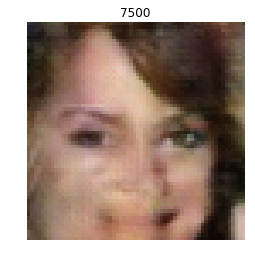

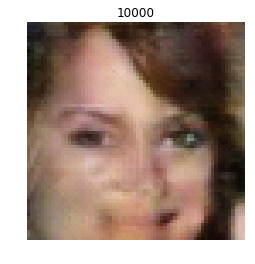

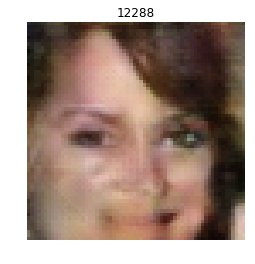

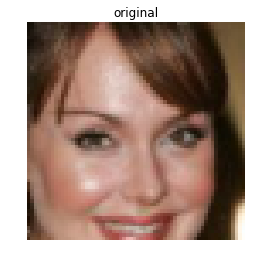

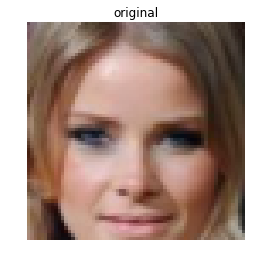

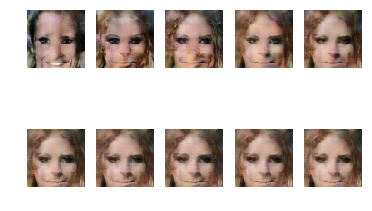

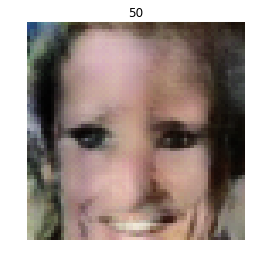

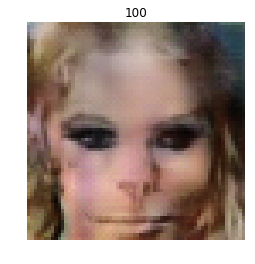

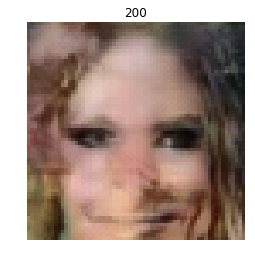

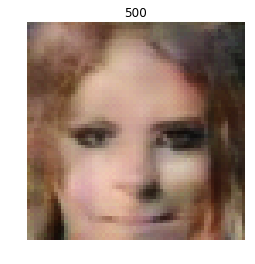

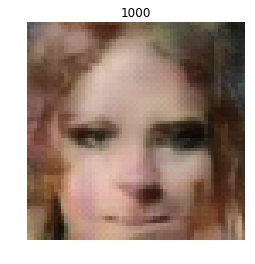

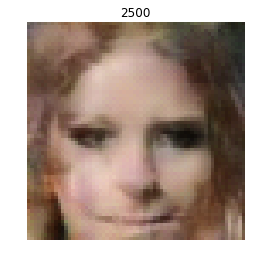

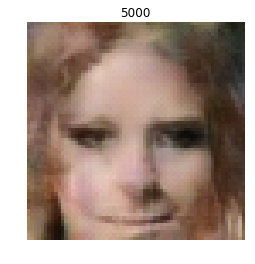

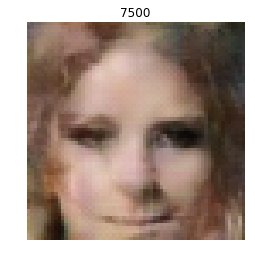

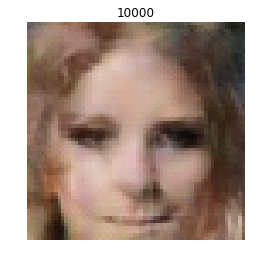

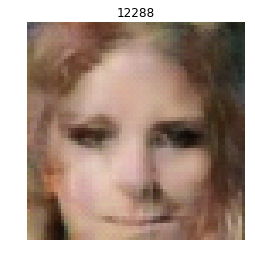

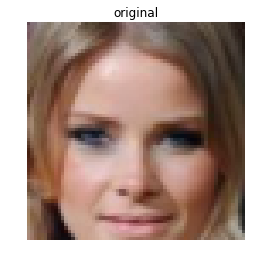

In [11]:
#image_num = 0

for image_num in range(10):

    plt.figure()
    plt.title("original")
    plt.imshow((sample[image_num] + 1.0)/2.0) 
    plt.axis('off')

    fig = plt.figure()
    for i in range(len(compressed_images)):
        im = fig.add_subplot(2, len(compressed_images) / 2, i + 1)
        plt.imshow((compressed_images[i][image_num] + 1.0)/2.0)
        plt.axis('off')

    for i in range(len(compressed_images)):
        plt.figure()
        plt.title(possible_ms[i])
        plt.imshow((compressed_images[i][image_num] + 1.0)/2.0)
        plt.axis('off')
        plt.figure()
    plt.title("original")
    plt.imshow((sample[image_num] + 1.0)/2.0) 
    plt.axis('off')